# ARIMA Forecasting in aeon


Experimental functions. Note Im not sure the 

In [1]:
import traceback
from aeon_benchmark.forecasting.arima import (get_fixed_stationary_arma_params, 
                                              make_statsforecast_df, 
                                              simulate_arma_data, 
stationary_arma_models)
import numpy as np
import pandas as pd
from aeon.forecasting.stats import AutoARIMA as AeonAutoARIMA
from aeon.forecasting.stats import ARIMA as AeonARIMA
from statsforecast import StatsForecast
from statsforecast.models import ARIMA as SF_ARIMA
from statsforecast.models import AutoARIMA as SF_AutoARIMA
import warnings
warnings.filterwarnings("ignore")
import time, os
import matplotlib.pyplot as plt
import seaborn as sns

def compare_arma_forecasters(lengths, m=5, sigma=1.0, seed_base=0):
    """
    Compare forecasters over increasing serlsies lengths.

    Parameters
    ----------
    lengths : list of int
        Series lengths to evaluate.
    m : int
        Repetitions per length.
    sigma : float
        Std dev of noise in simulated data.
    seed_base : int
        Base seed to ensure reproducibility.

    Returns
    -------
    pandas.DataFrame
        Average MSE and time per method per length.
    """
    results = []
    # Warm up for numba
    n = 100
    ar_params, ma_params, p, q = get_fixed_stationary_arma_params(stationary_arma_models, seed=100)
    y = simulate_arma_data(ar_params, ma_params, n_samples=n, sigma=sigma, seed=100)
    aeon_model = AeonARIMA().fit(y)
    aeon_auto_model = AeonAutoARIMA().fit(y)
    df = make_statsforecast_df(y)
    sf = StatsForecast(models=[SF_ARIMA(order=(1, 0, 1))], freq="H")
    forecast_df = sf.forecast(df=df, h=1)
    forecast = forecast_df.iloc[0]["ARIMA"]

    for n in lengths:
        print(" Beginning length ",n)
        for i in range(m):
            seed = seed_base + i + n * 1000

            # Generate parameters and data
            ar_params, ma_params, p, q = get_fixed_stationary_arma_params(stationary_arma_models, seed=seed)
            y = simulate_arma_data(ar_params, ma_params, n_samples=n, sigma=sigma, seed=seed)
            y = (y - np.mean(y)) / np.std(y)
            y_train = y[:-1]
            y_test = y[-1:]
            # --- Statsforecast ---
            try:
                df = make_statsforecast_df(y_train)
                t0 = time.time()
                sf = StatsForecast(models=[SF_ARIMA(order=(p,0,q))],
                                    freq="H")
                forecast_df = sf.forecast(df=df, h=1)
                forecast = forecast_df.iloc[0]["ARIMA"]
                t1 = time.time()
                error = y_test[0] - forecast
                mse = float(error ** 2)
                sf_mse = mse
                results.append({"method": 'statsforecast_true', "n": n, "mse": mse, "time": t1-t0,"model": [p,q]})
            except Exception as e:
                print("Stats forecast exception =  ",e)
            try:
                df = make_statsforecast_df(y_train)
                t0 = time.time()
                sf = StatsForecast(models=[SF_AutoARIMA()], freq="H")
                forecast_df = sf.forecast(df=df, h=1)
                forecast = forecast_df.iloc[0]["AutoARIMA"]
                t1 = time.time()
                error = y_test[0] - forecast
                mse = float(error ** 2)
                results.append({"method": 'statsforecast_auto', "n": n, "mse": mse, "time": t1-t0,"model": [p,q]})
            except Exception as e:
                print("Stats forecast exception =  ",e)
            # --- Aeon ---
            try:
                t0 = time.time()
                aeon_model = AeonARIMA(p=p, d=0, q=q, use_constant=True)
                aeon_model.fit(y_train)
                forecast = aeon_model.forecast_
                t1 = time.time()
                error = y_test[0] - forecast
                mse = float(error ** 2)
                results.append({"method": 'aeon_true', "n": n, "mse": mse, "time": t1-t0,"model": [p,q]})
                if np.abs(mse-sf_mse)>10:
                    print("Occasionally Nelder-Mead fails terribly")
                    print(f"{mse} aeon {sf_mse} SF, length {n}, run {i} p ={p} q "
                            f"= {q} AR paras = {ar_params} MA params = {ma_params}")
                    print(f" series = {y} seed = {seed} AIC = {aeon_model.aic_} ")
            except Exception as e:
                print("aeon forecast exception =  ",e)
                traceback.print_exc()
            try:
                t0 = time.time()
                aeon_model = AeonAutoARIMA()
                aeon_model.fit(y_train)
                forecast = aeon_model.forecast_
                t1 = time.time()
                error = y_test[0] - forecast
                mse = float(error ** 2)
                results.append({"method": 'aeon_auto', "n": n, "mse": mse, "time": t1-t0,"model": [p,q]})
                if np.abs(mse-sf_mse)>10:
                    print("Occasionally Nelder-Mead fails terribly")
                    print(f"{mse} auto_aeon {sf_mse} SF, length {n}, run {i} p ={aeon_model.p_} q "
                            f"= {aeon_model.q_} d ={aeon_model.d_} phi = {aeon_model.final_model_.phi_} "
                            f"theta = {aeon_model.final_model_.theta_} c = {aeon_model.final_model_.c_} "
                            f"AR paras = {ar_params} MA params = {ma_params}")
                    print(f" series = {y} seed = {seed} AIC = {aeon_model.fit_aic_} ")
            except Exception as e:
                print("auto_aeon forecast exception =  ",e)
                traceback.print_exc()
    df_results = pd.DataFrame(results)
    return df_results

def plot_mse_and_runtime_by_library(df_results):
    """
    Plot MSE and total runtime for each library (statsmodels, statsforecast, aeon),
    separately for true and baseline models. Also print tables comparing
    statsforecast and aeon against statsmodels.

    Parameters
    ----------
    df_results : pd.DataFrame
        Must contain columns: ['method', 'n', 'mse', 'time']
    """
    sns.set(style="whitegrid", font_scale=1.2)
    df = df_results.copy()

    # Extract library and model type (true or baseline)
    df["library"] = df["method"].str.extract(r"^(statsforecast|aeon)")
    df["model_type"] = df["method"].str.extract(r"_(true|auto)")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

    for i, (metric, agg) in enumerate([("mse", "mean"), ("time", "sum")]):
        for j, model_type in enumerate(["true", "auto"]):
            ax = axes[i, j]
            data = df[df["model_type"] == model_type]

            summary = data.groupby(["library", "n"]).agg(
                mean=(metric, agg),
                std=(metric, "std")
            ).reset_index()

            sns.lineplot(
                data=summary,
                x="n",
                y="mean",
                hue="library",
                marker="o",
                err_style="band",
                err_kws={"alpha": 0.2},
                ax=ax
            )

            label = "Mean Squared Error" if metric == "mse" else "Total Runtime (seconds)"
            ax.set_title(f"{label} vs n ({model_type} models)")
            ax.set_xlabel("Series Length (n)")
            ax.set_ylabel(label)
            if metric == "time":
                ax.set_yscale("log")
            ax.grid(True)
            ax.legend(title="Library")

    plt.tight_layout()
    plt.show()




c:\Users\alexb\Documents\Git Repos\aeon\venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
c:\Users\alexb\Documents\Git Repos\aeon\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Basic experiment

In [7]:
results = []
for i in range(1, 25):
    results.append(compare_arma_forecasters(lengths=[200, 300, 400, 500, 600, 700, 800, 900, 1000], 
                                    m=10, 
                                    sigma=1.0, seed_base=i*8))

 Beginning length  200
 Beginning length  300
 Beginning length  400
 Beginning length  500
 Beginning length  600
 Beginning length  700
 Beginning length  800
 Beginning length  900
 Beginning length  1000
 Beginning length  200
 Beginning length  300
 Beginning length  400
 Beginning length  500
 Beginning length  600
 Beginning length  700
 Beginning length  800
 Beginning length  900
 Beginning length  1000
 Beginning length  200
 Beginning length  300
 Beginning length  400
 Beginning length  500
 Beginning length  600
 Beginning length  700
 Beginning length  800
 Beginning length  900
 Beginning length  1000
 Beginning length  200
 Beginning length  300
 Beginning length  400
 Beginning length  500
 Beginning length  600
 Beginning length  700
 Beginning length  800
 Beginning length  900
 Beginning length  1000
 Beginning length  200
 Beginning length  300
 Beginning length  400
 Beginning length  500
 Beginning length  600
 Beginning length  700
 Beginning length  800
 Beginn

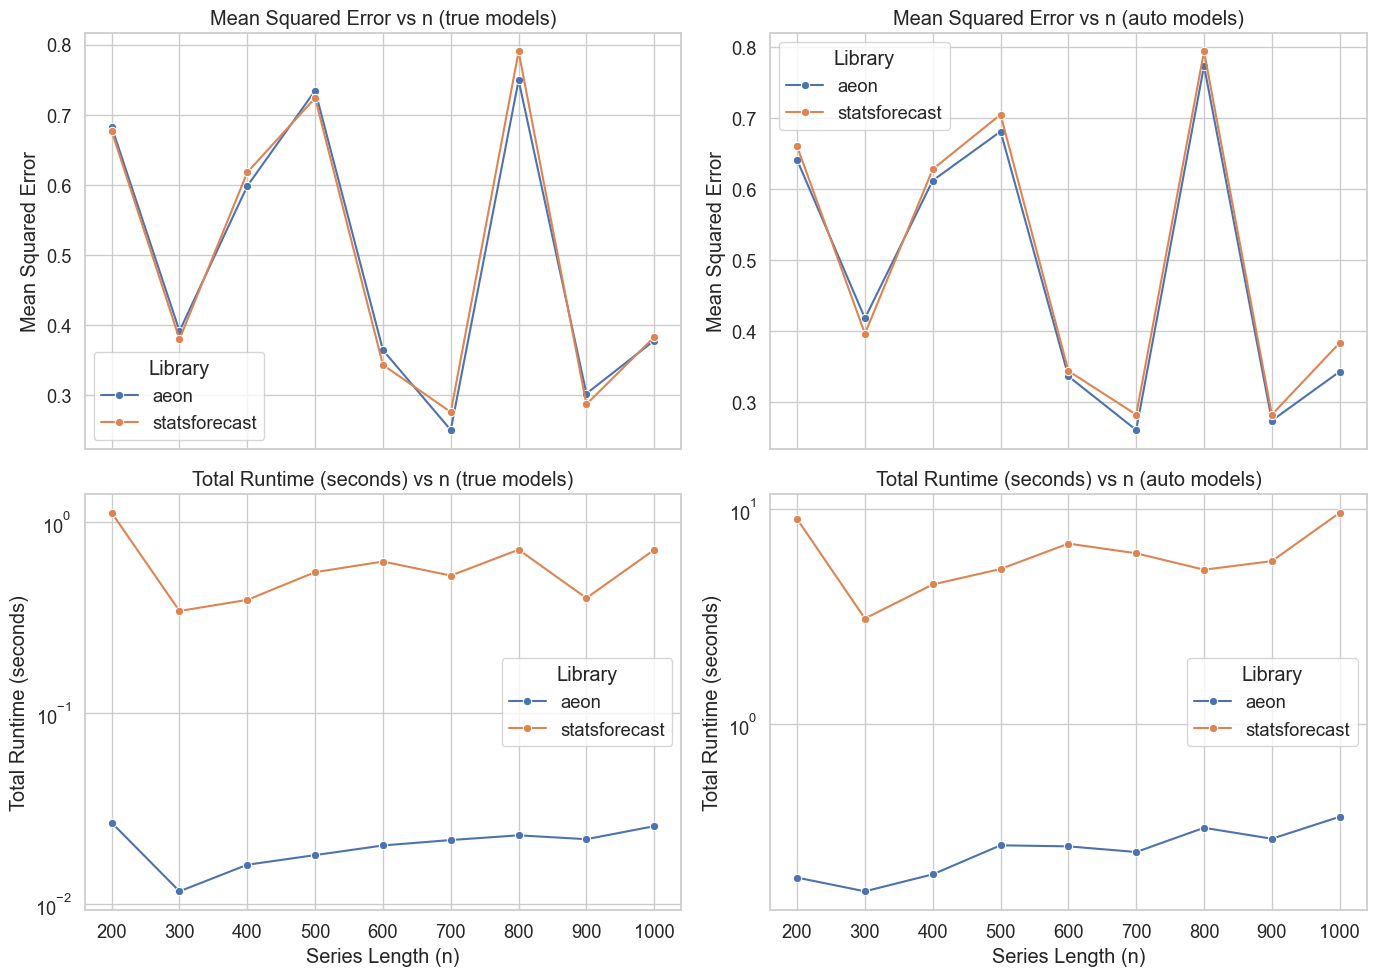

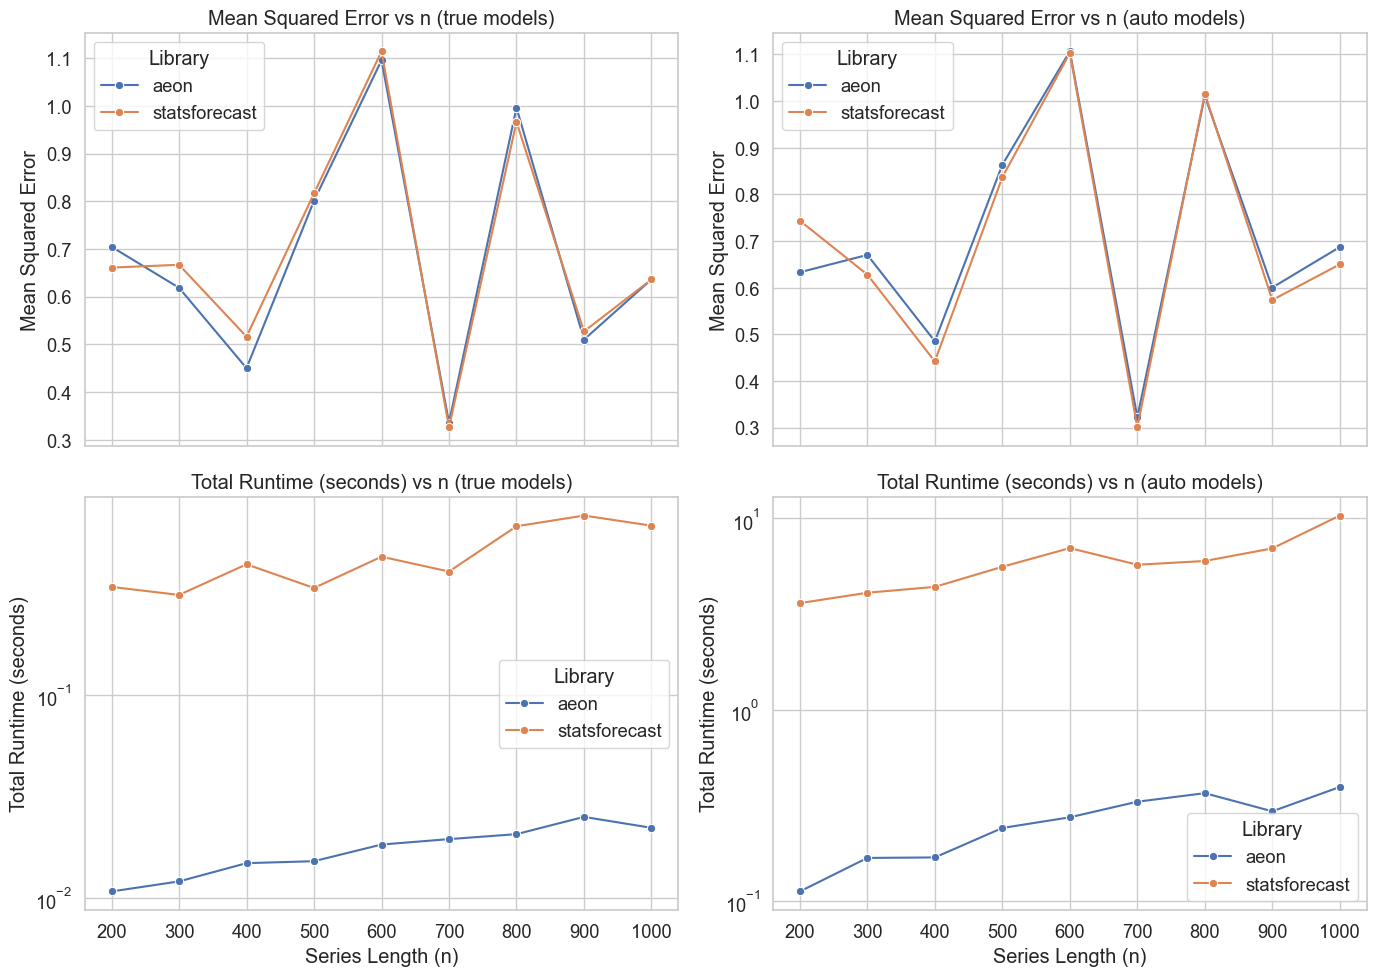

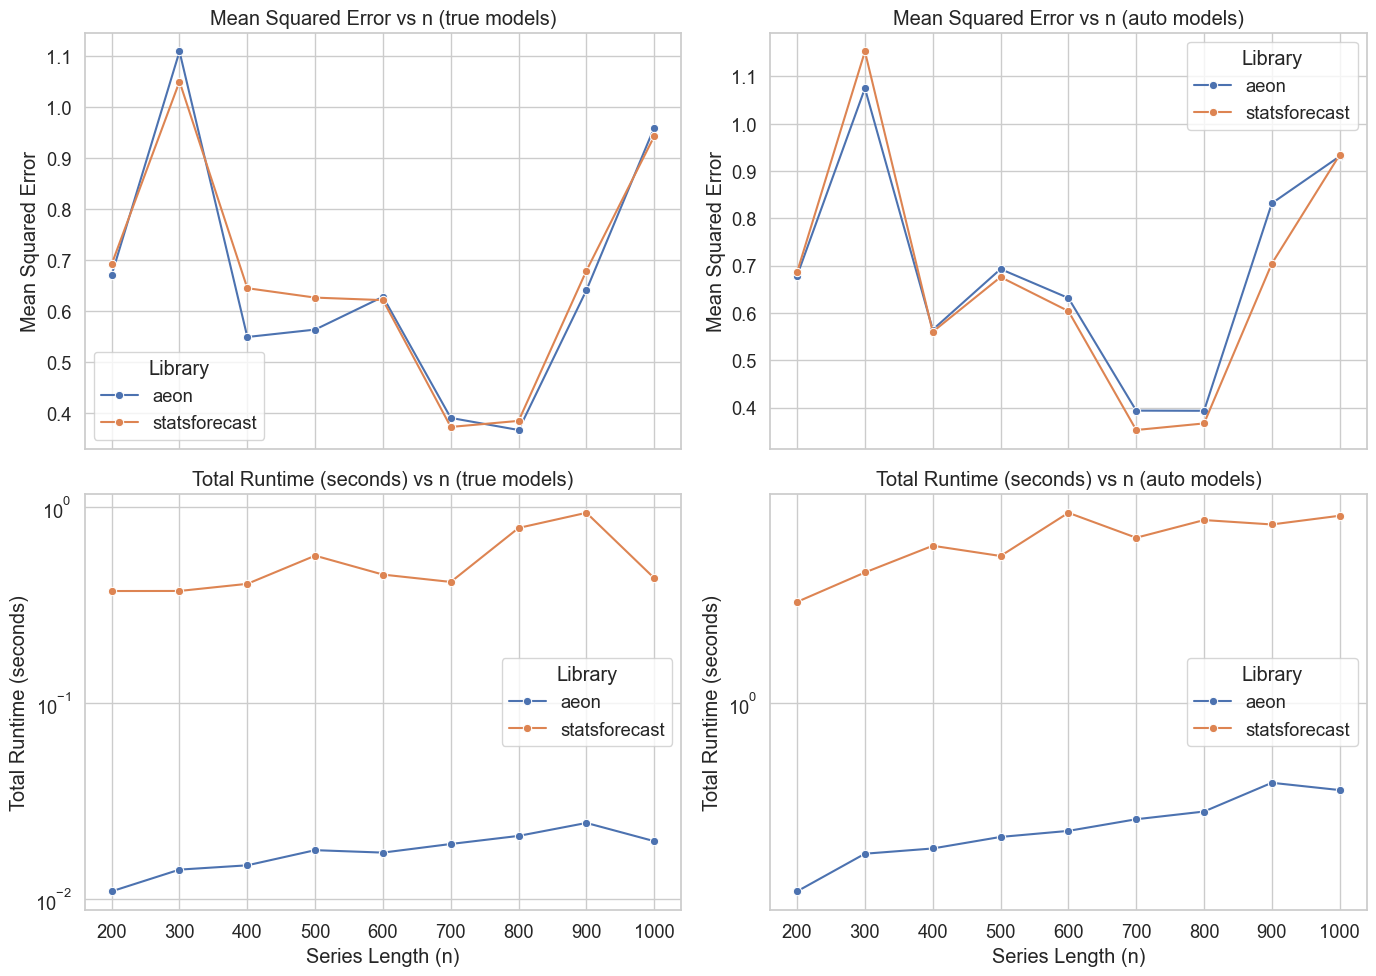

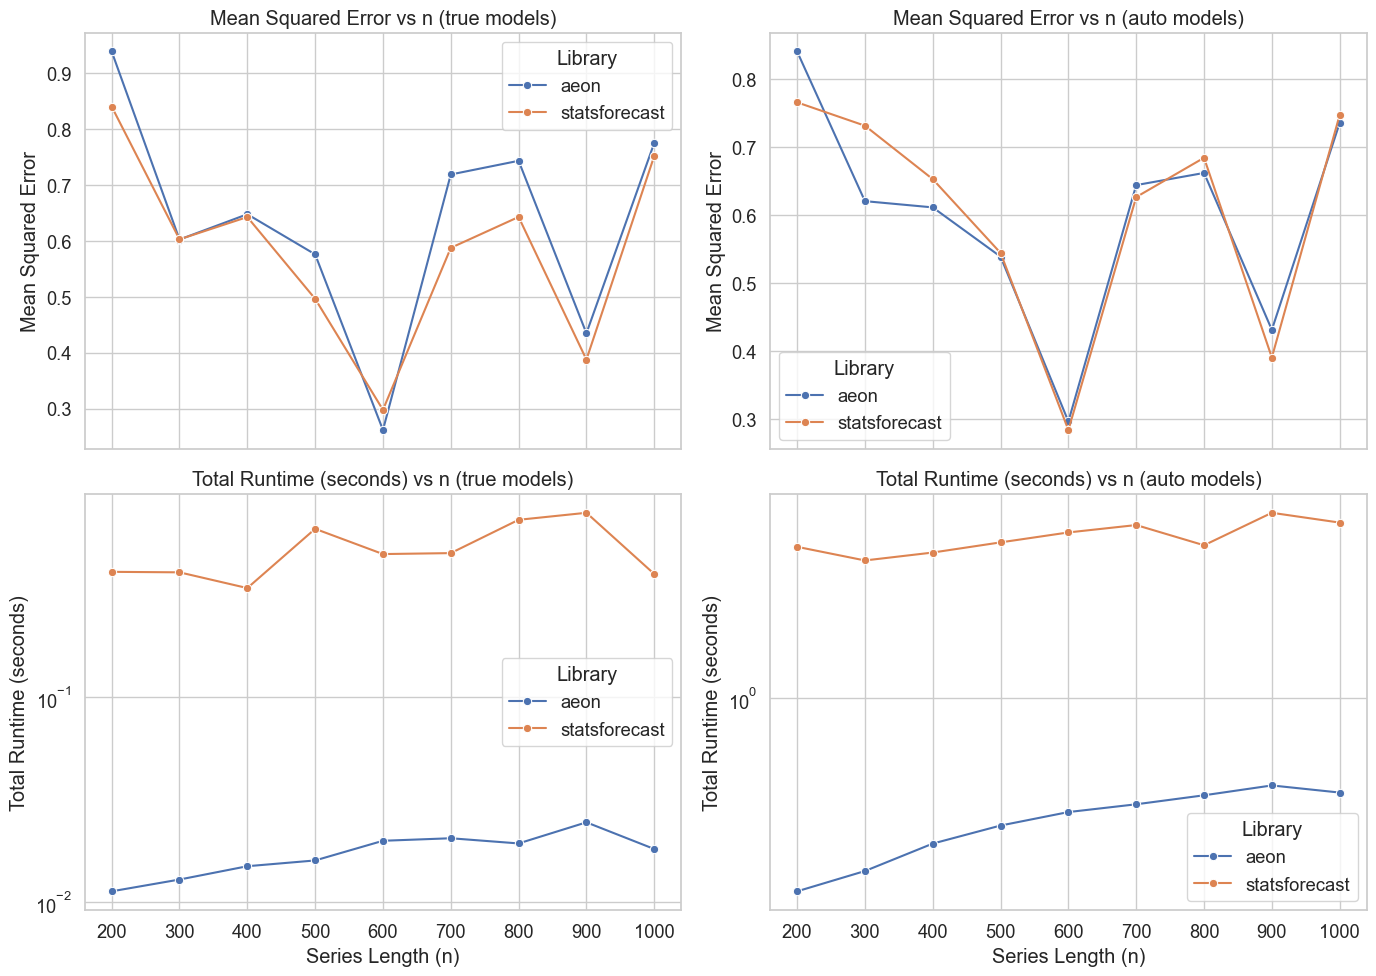

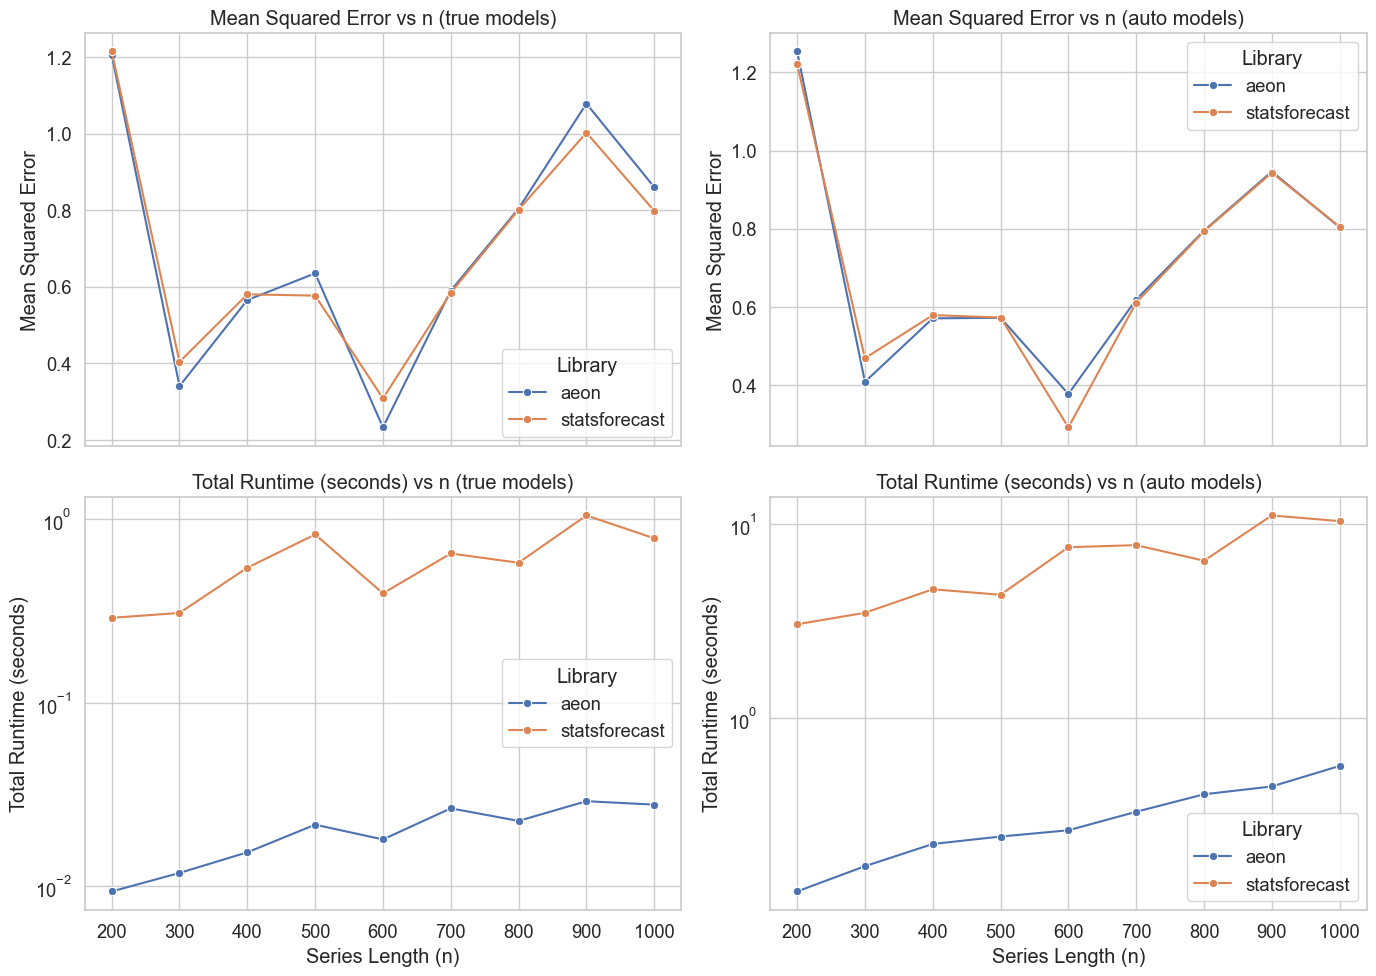

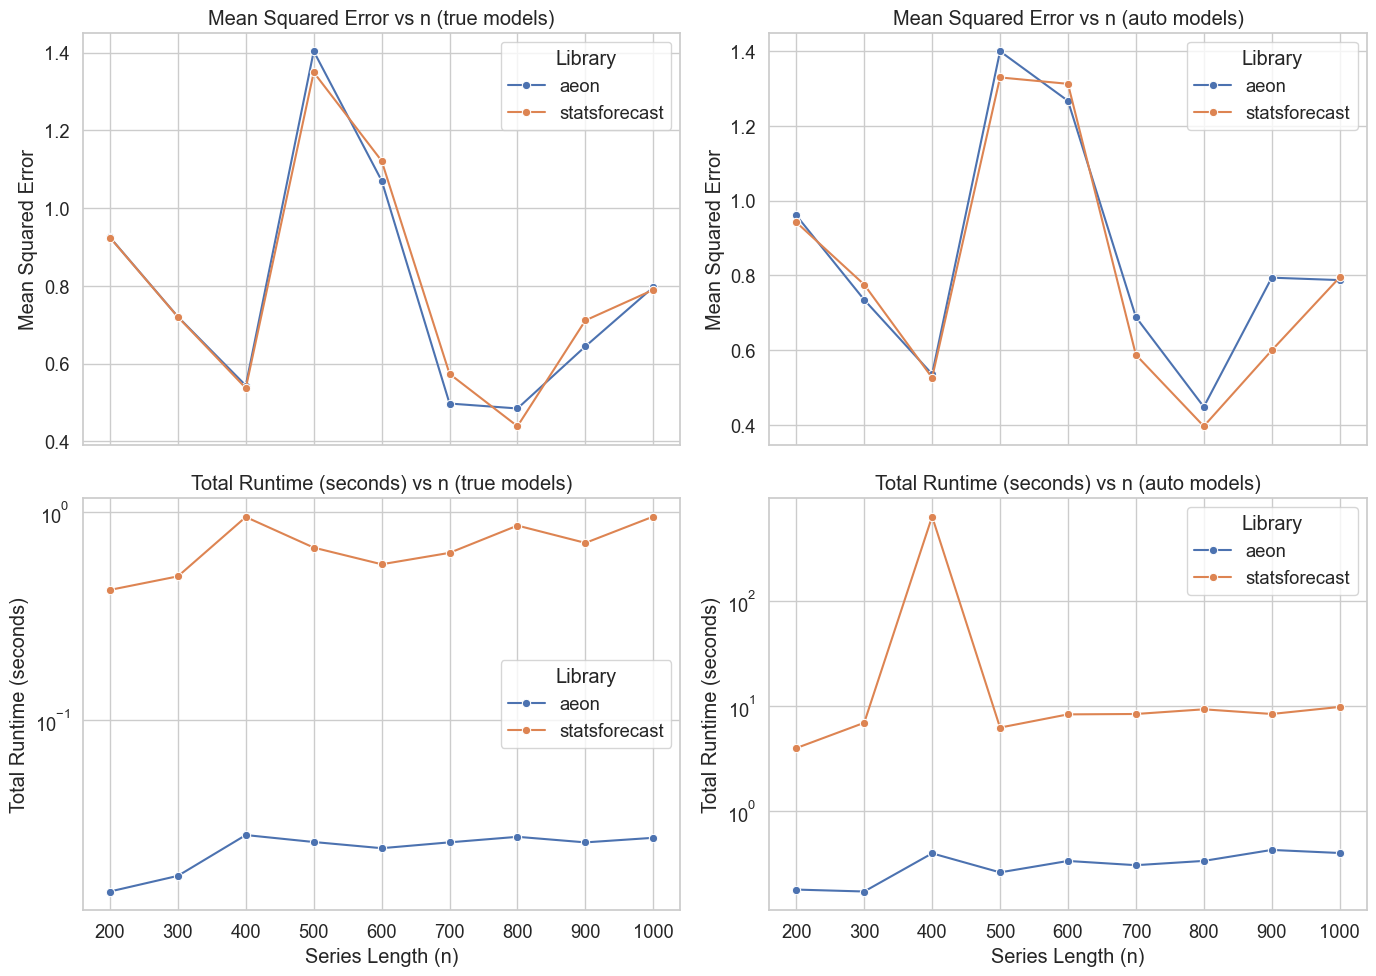

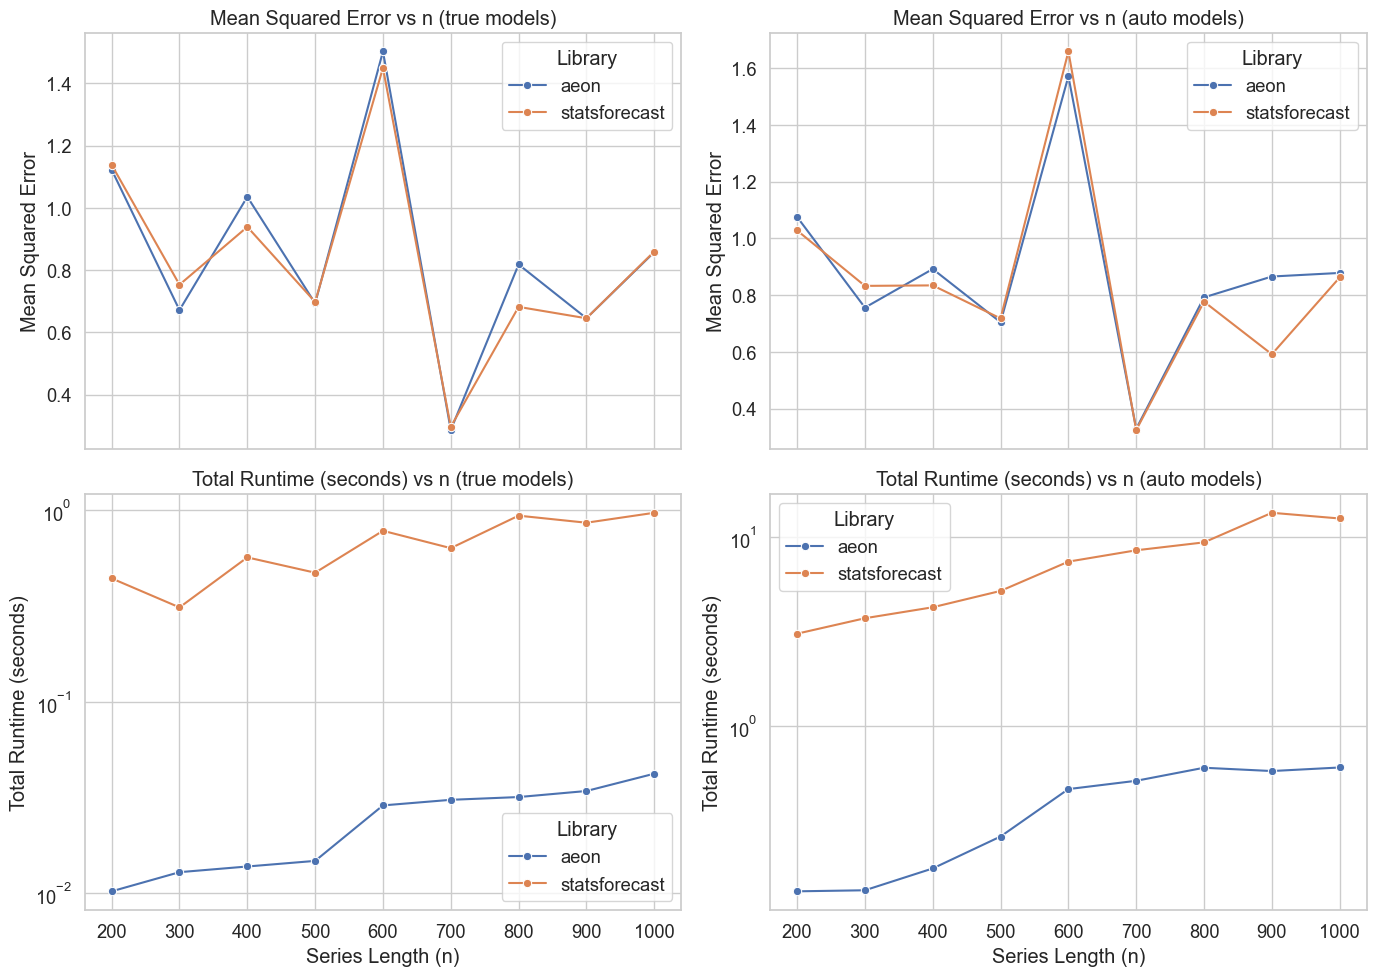

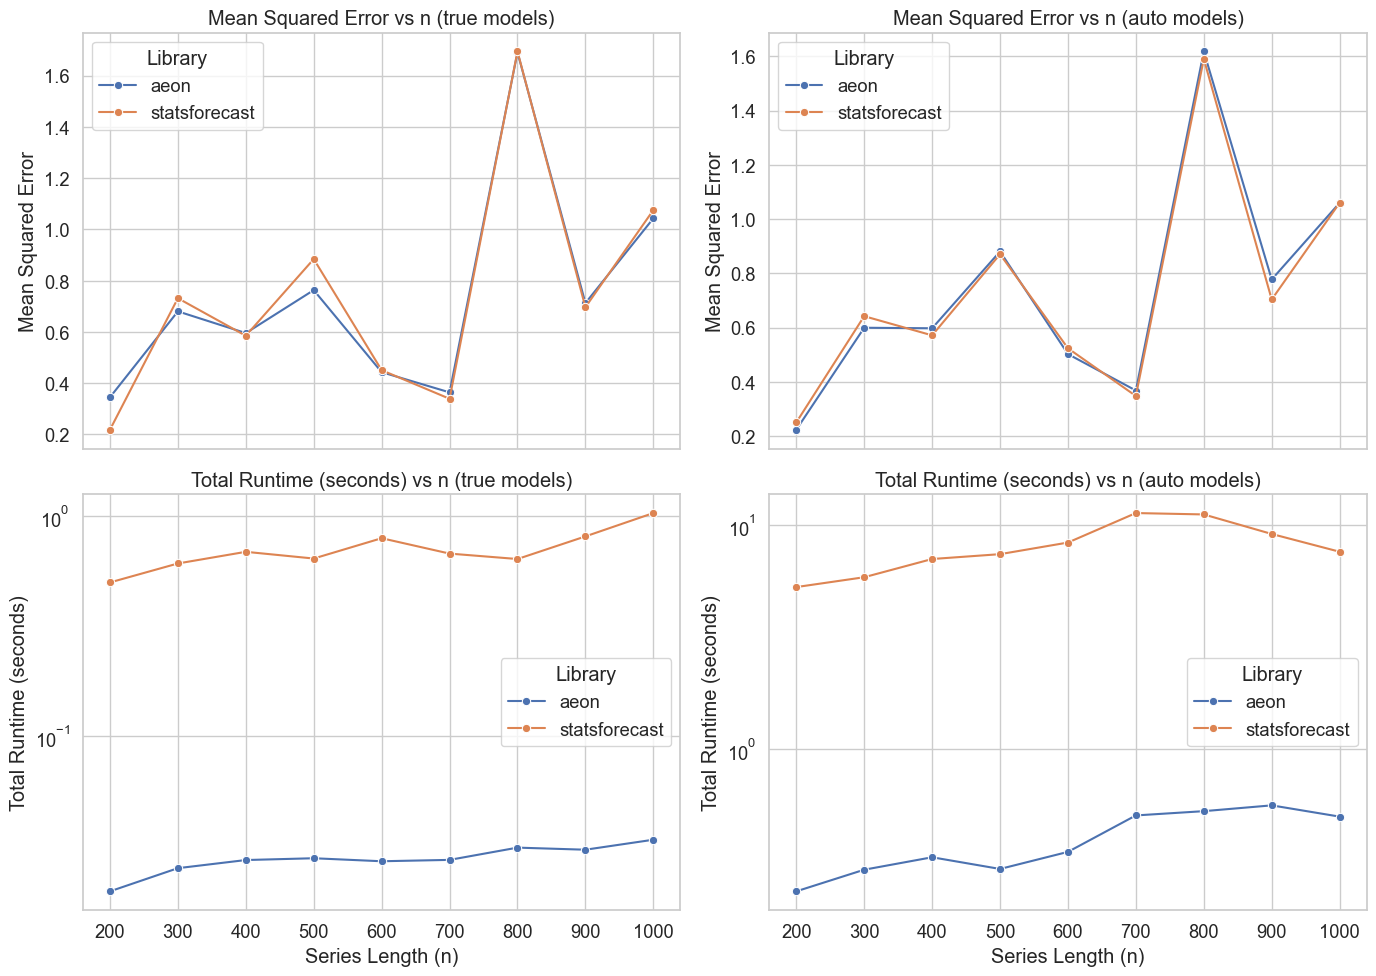

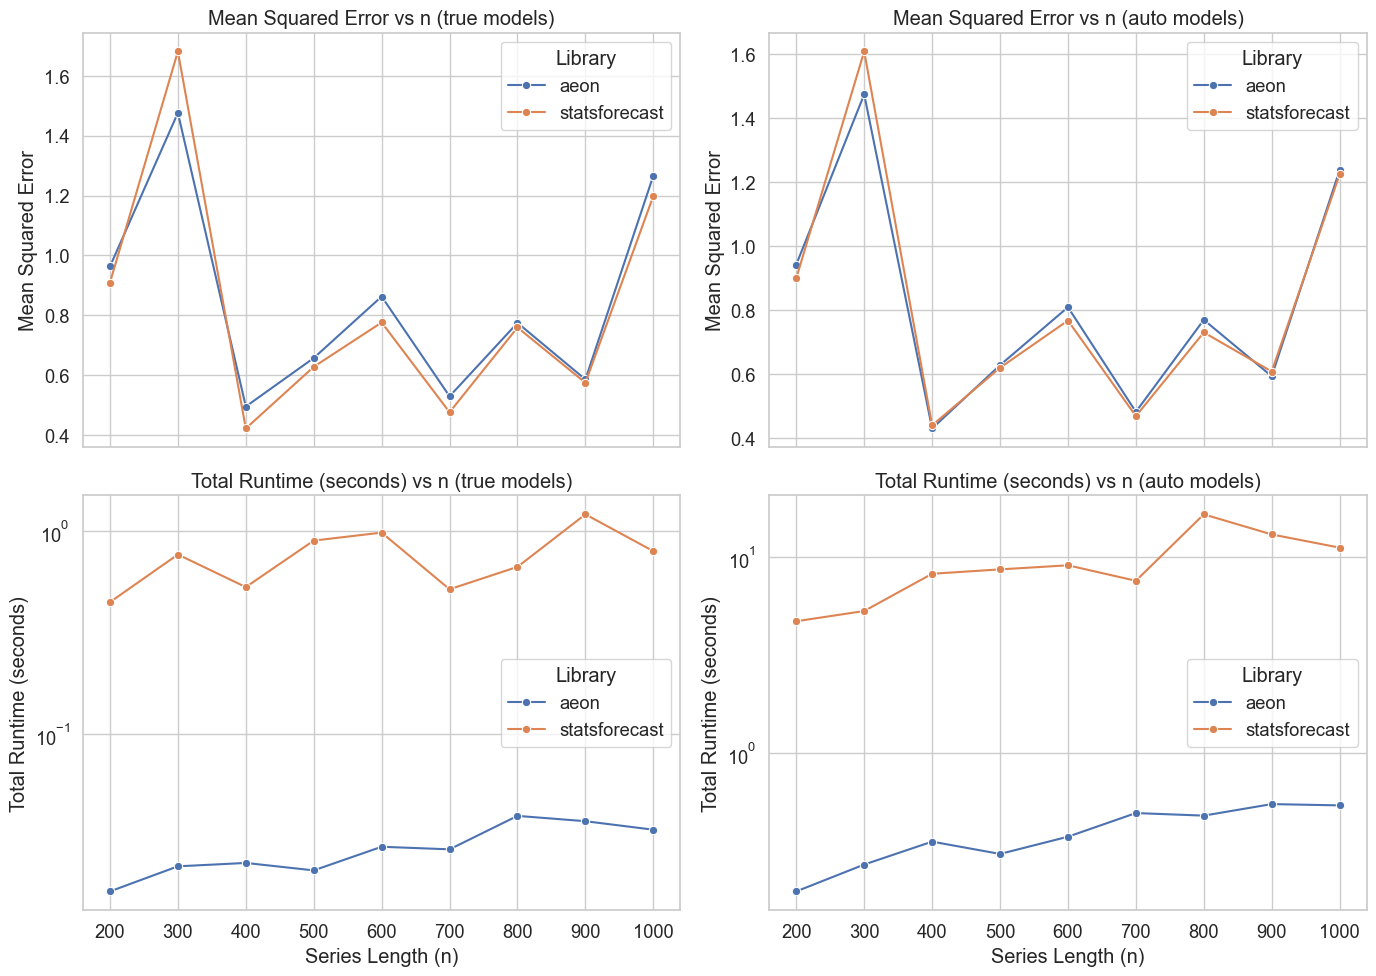

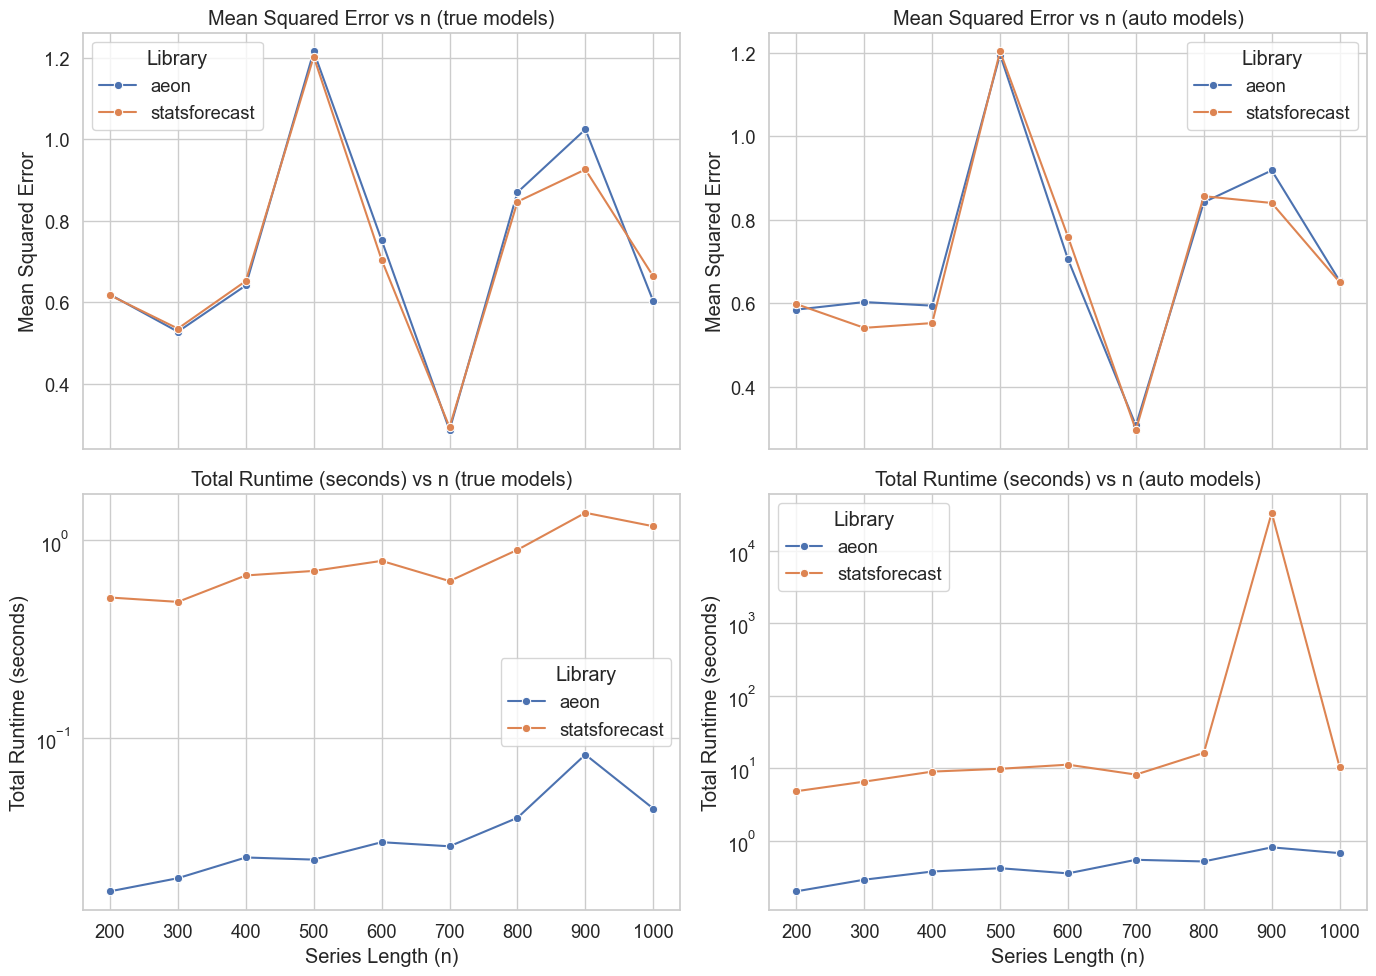

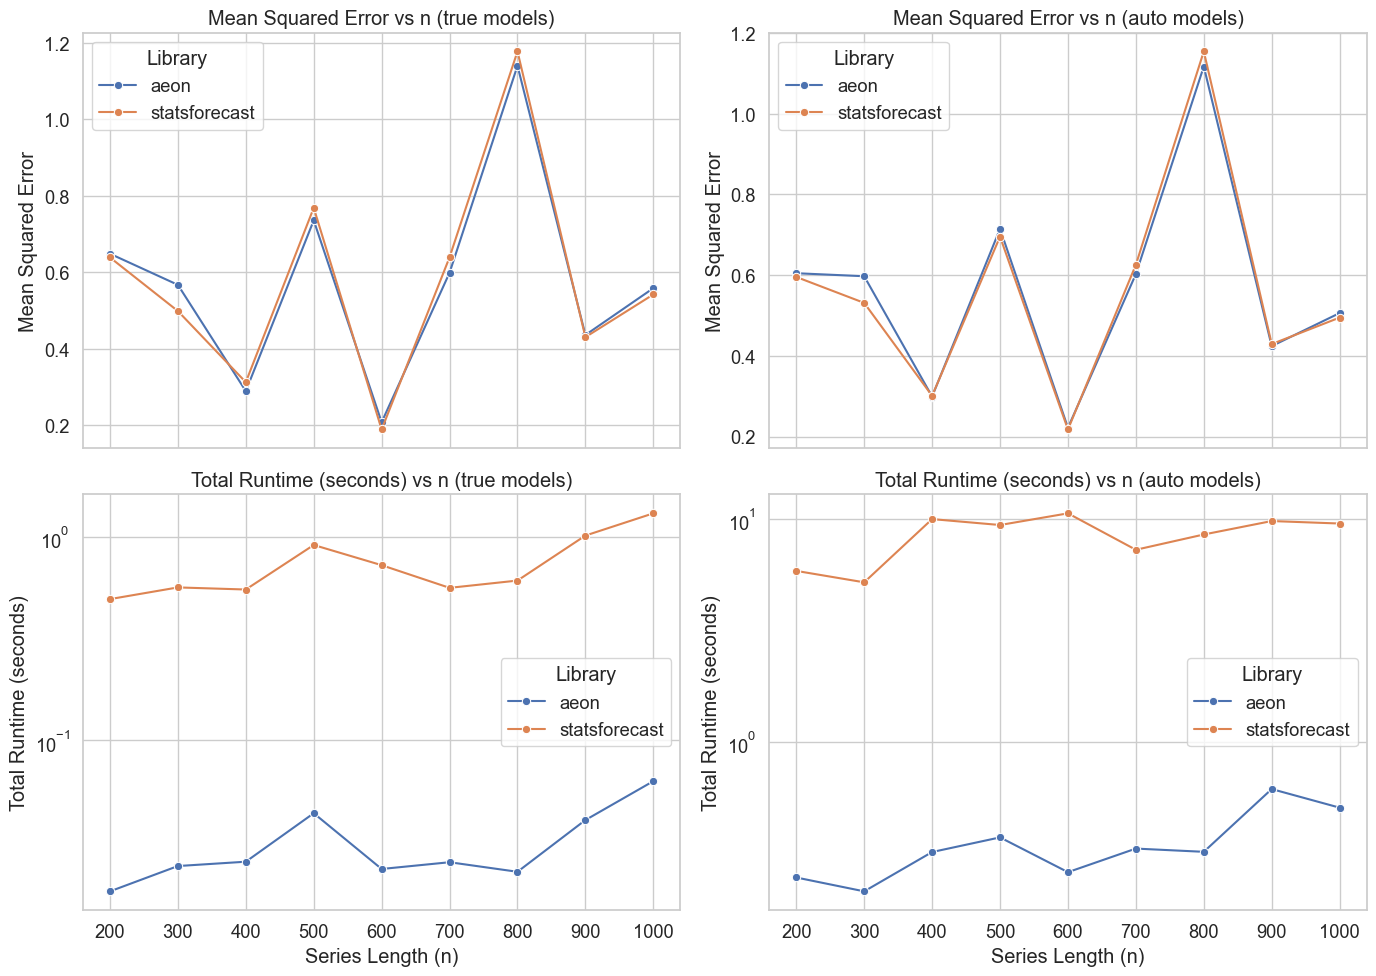

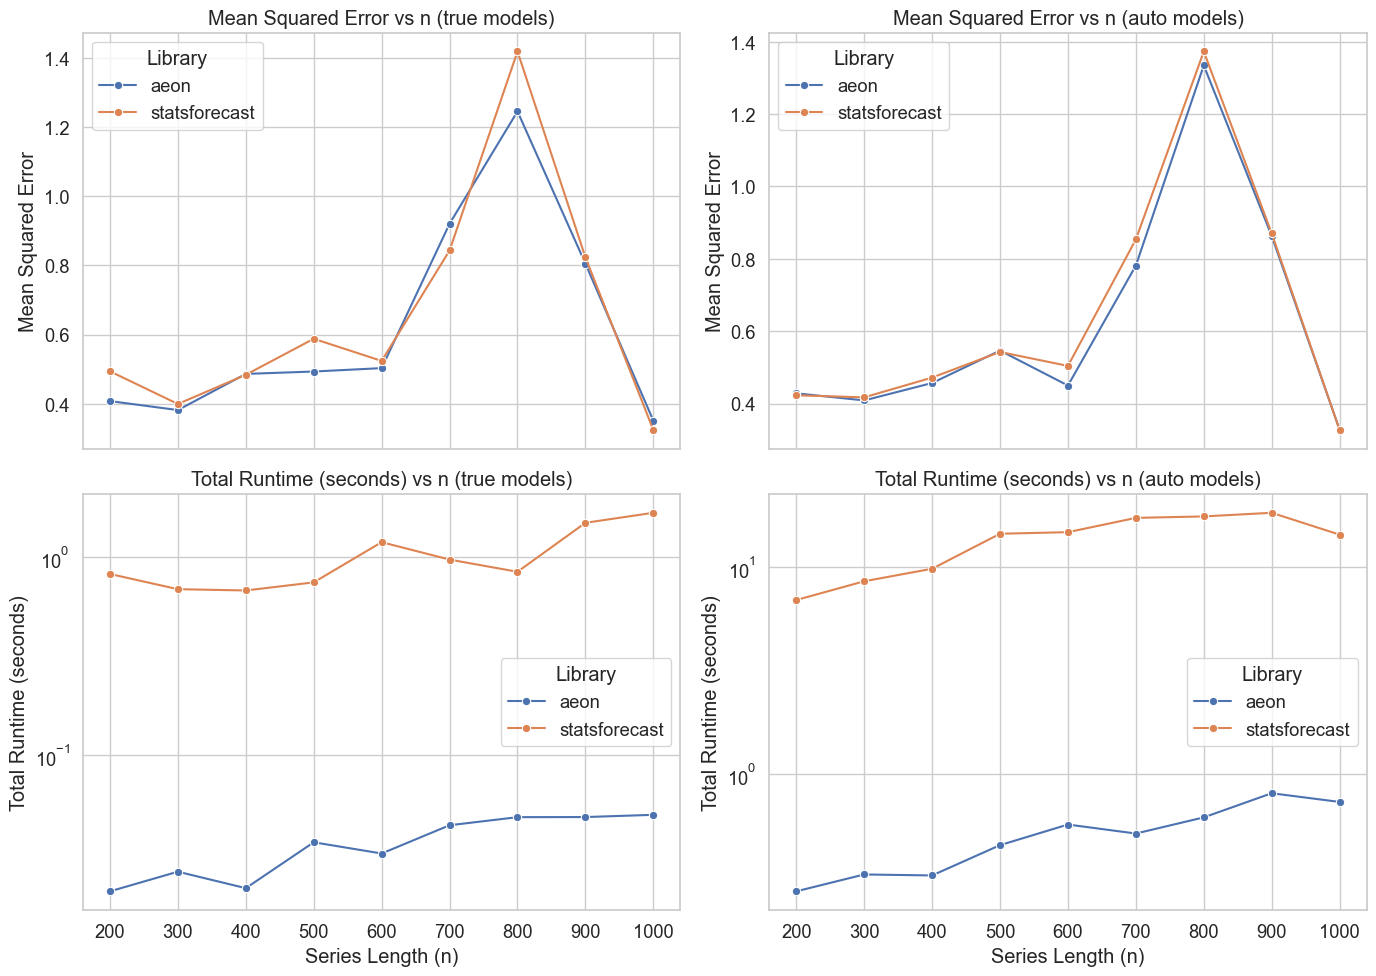

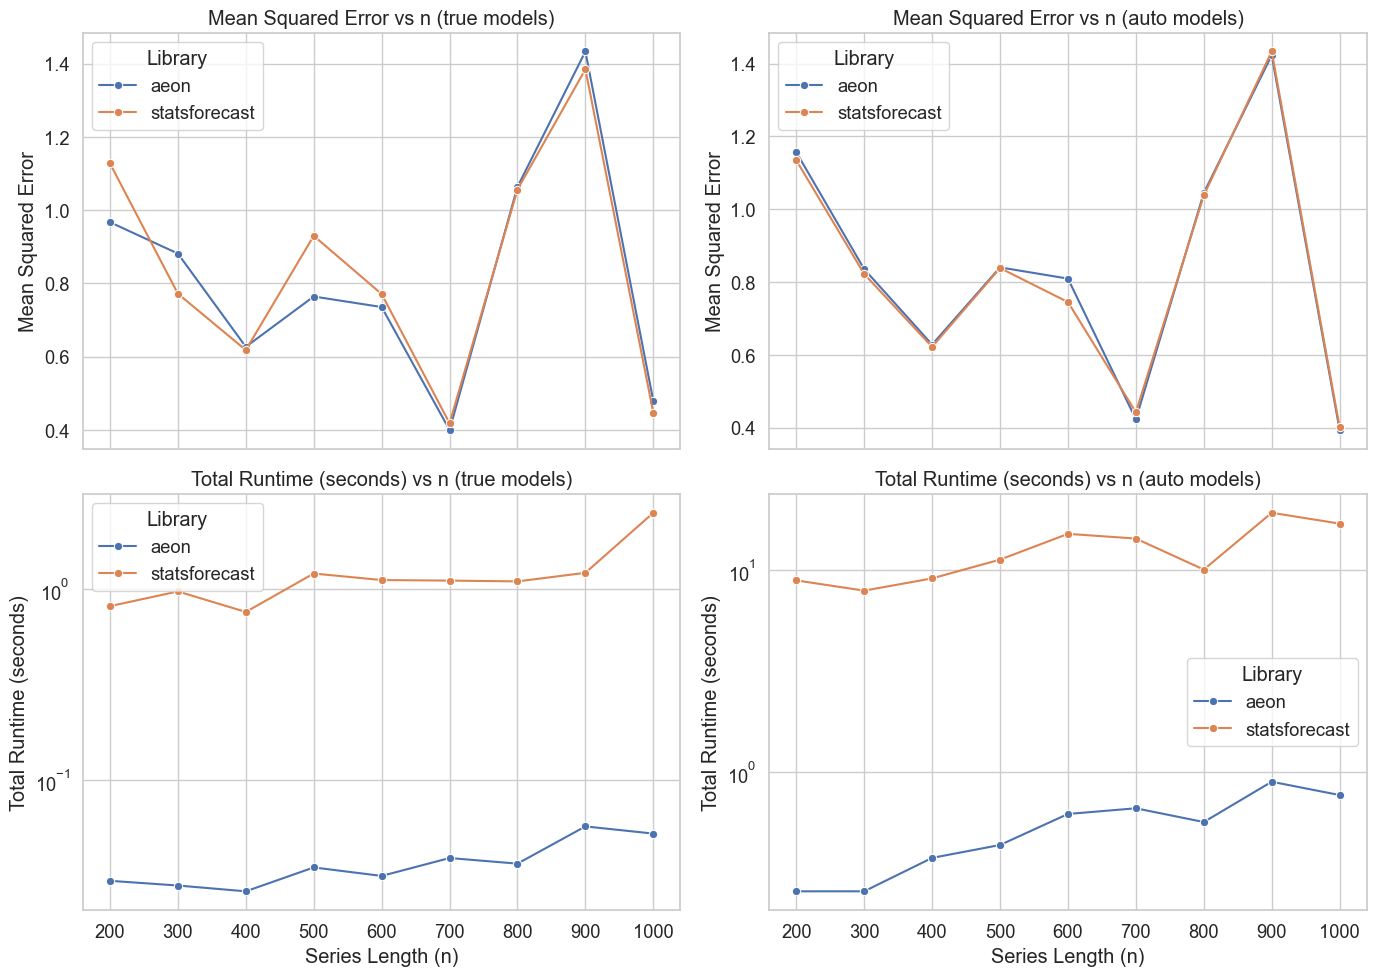

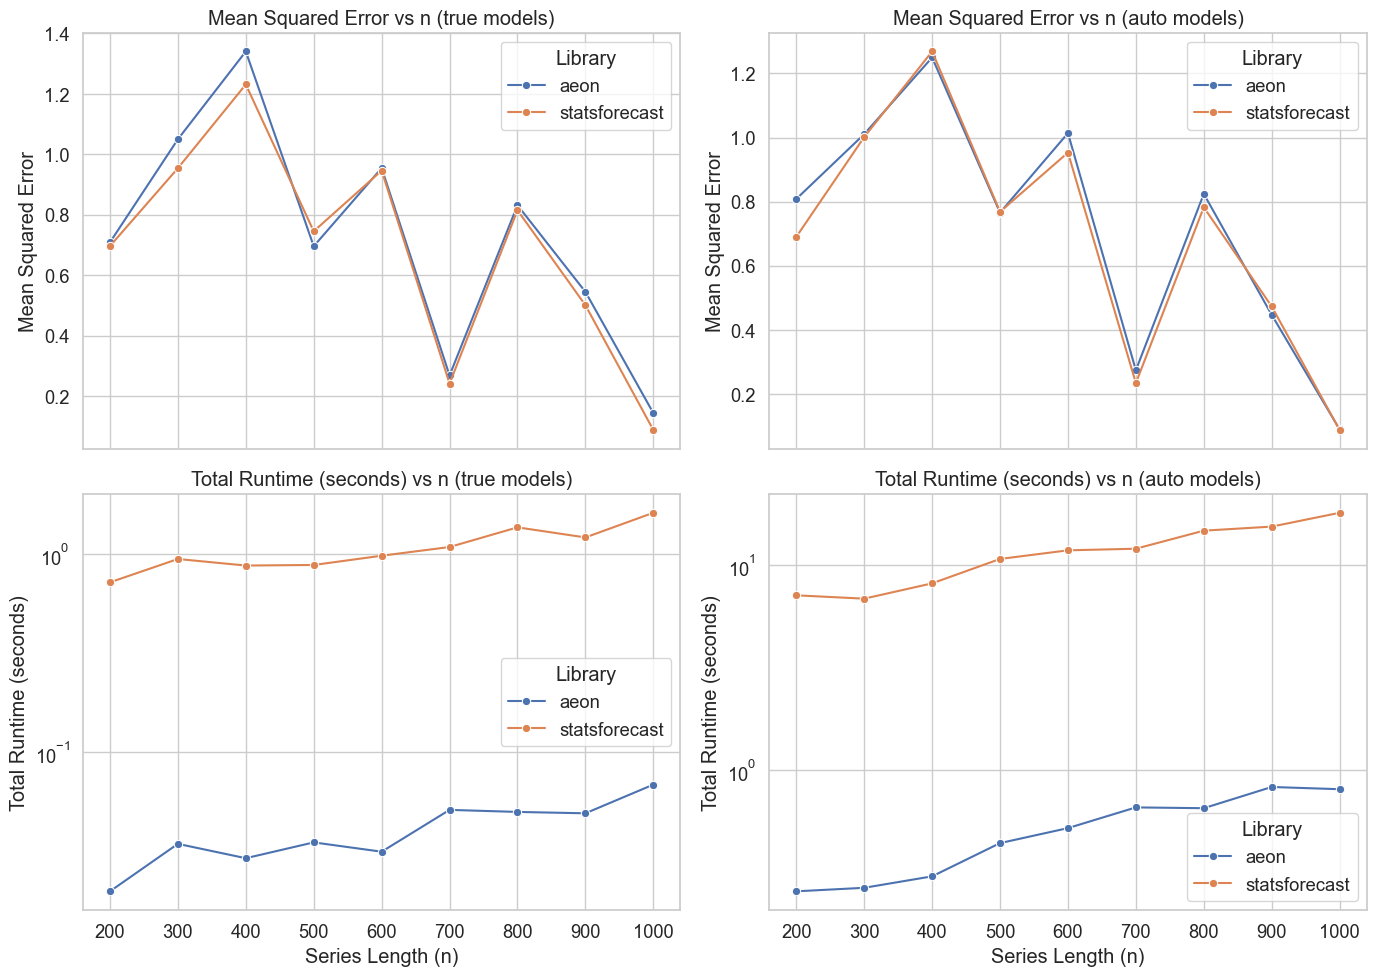

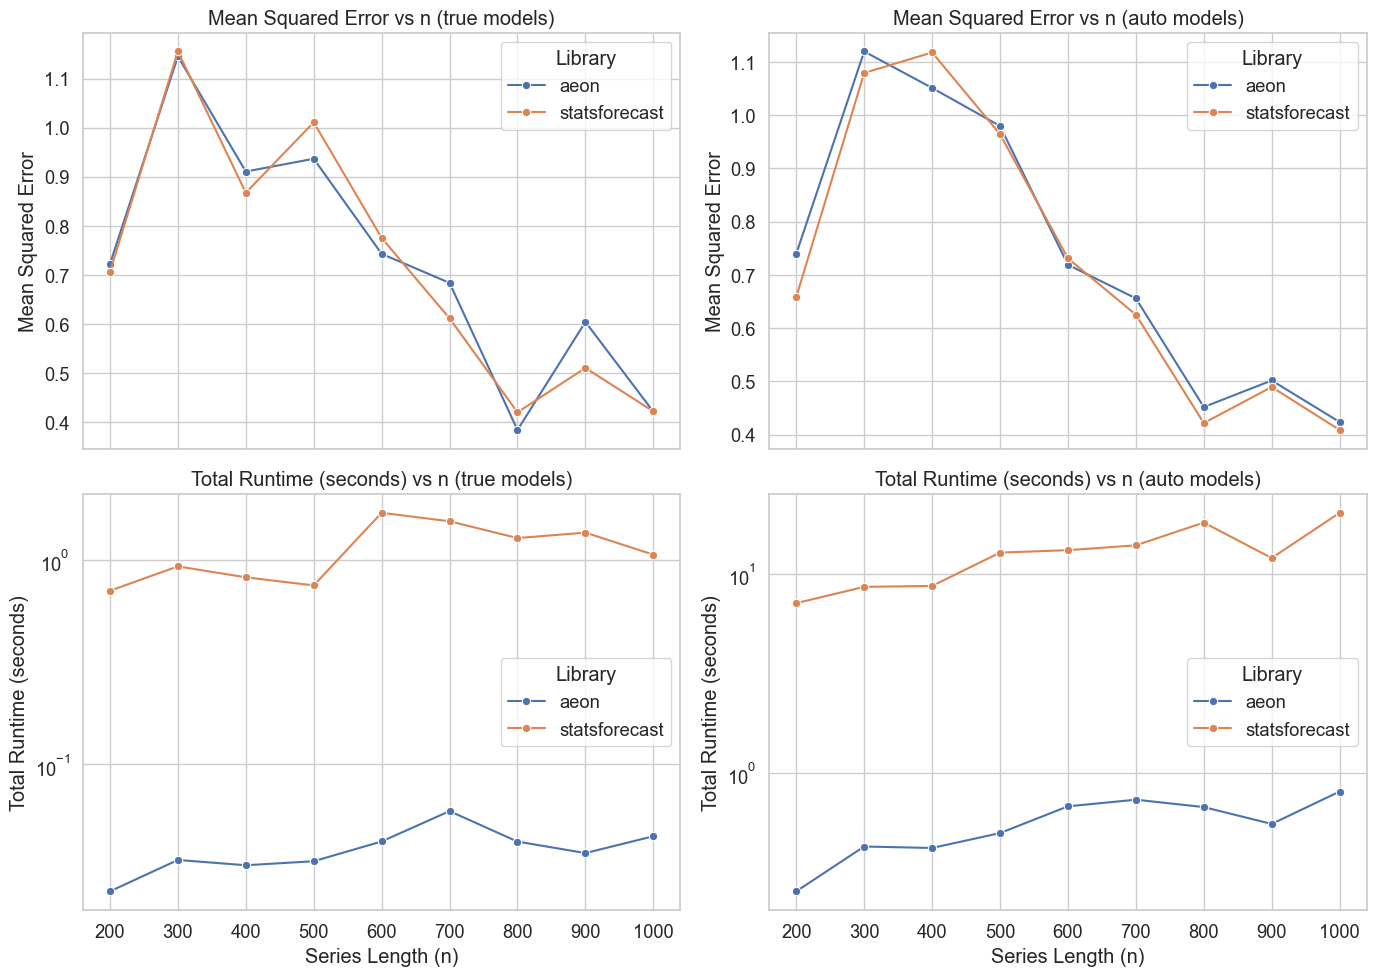

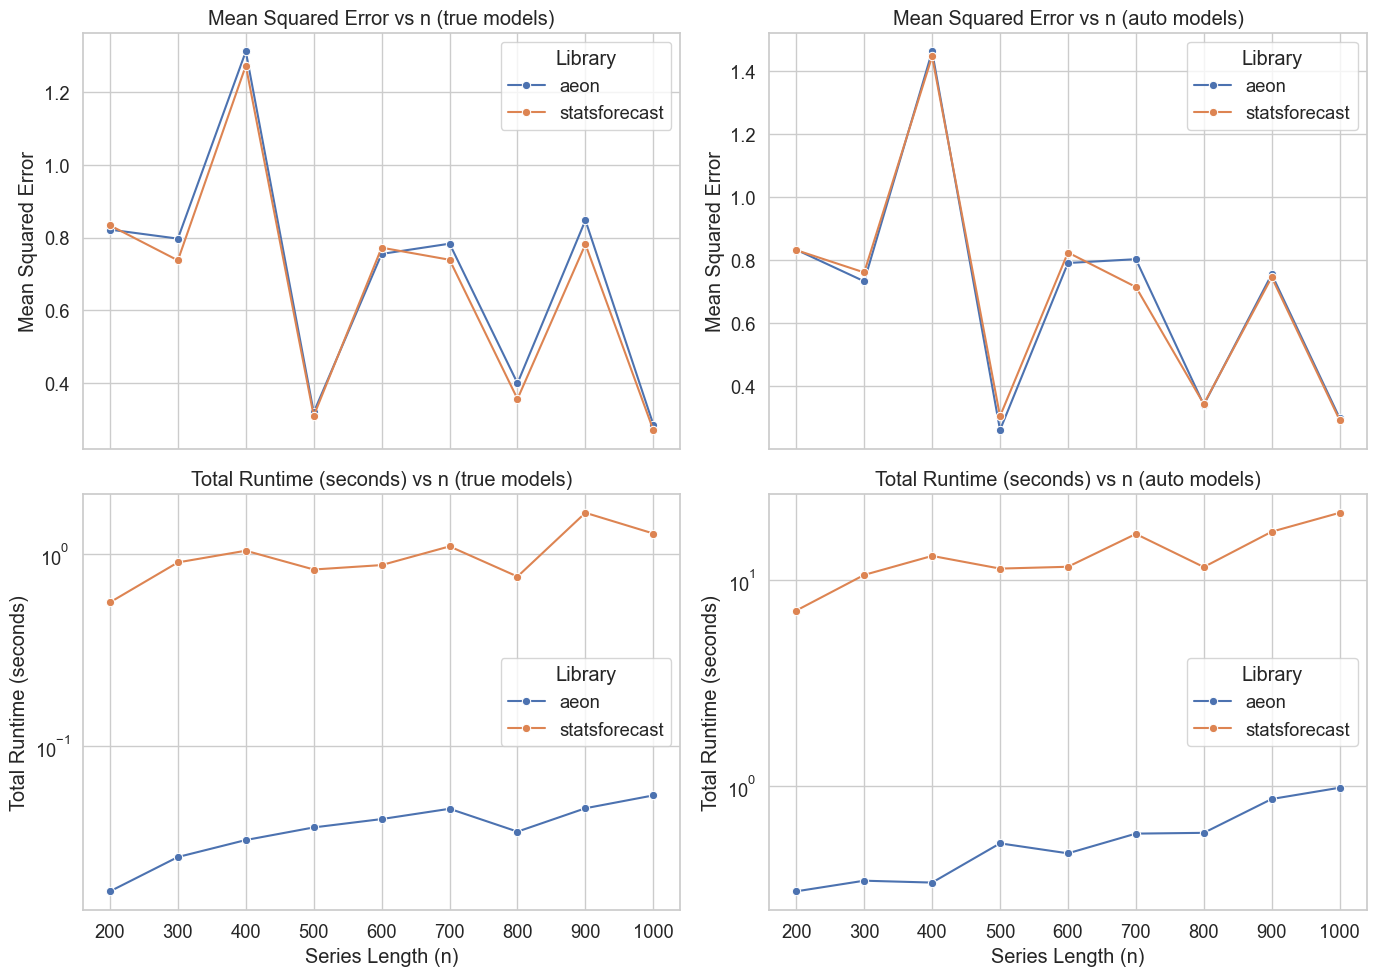

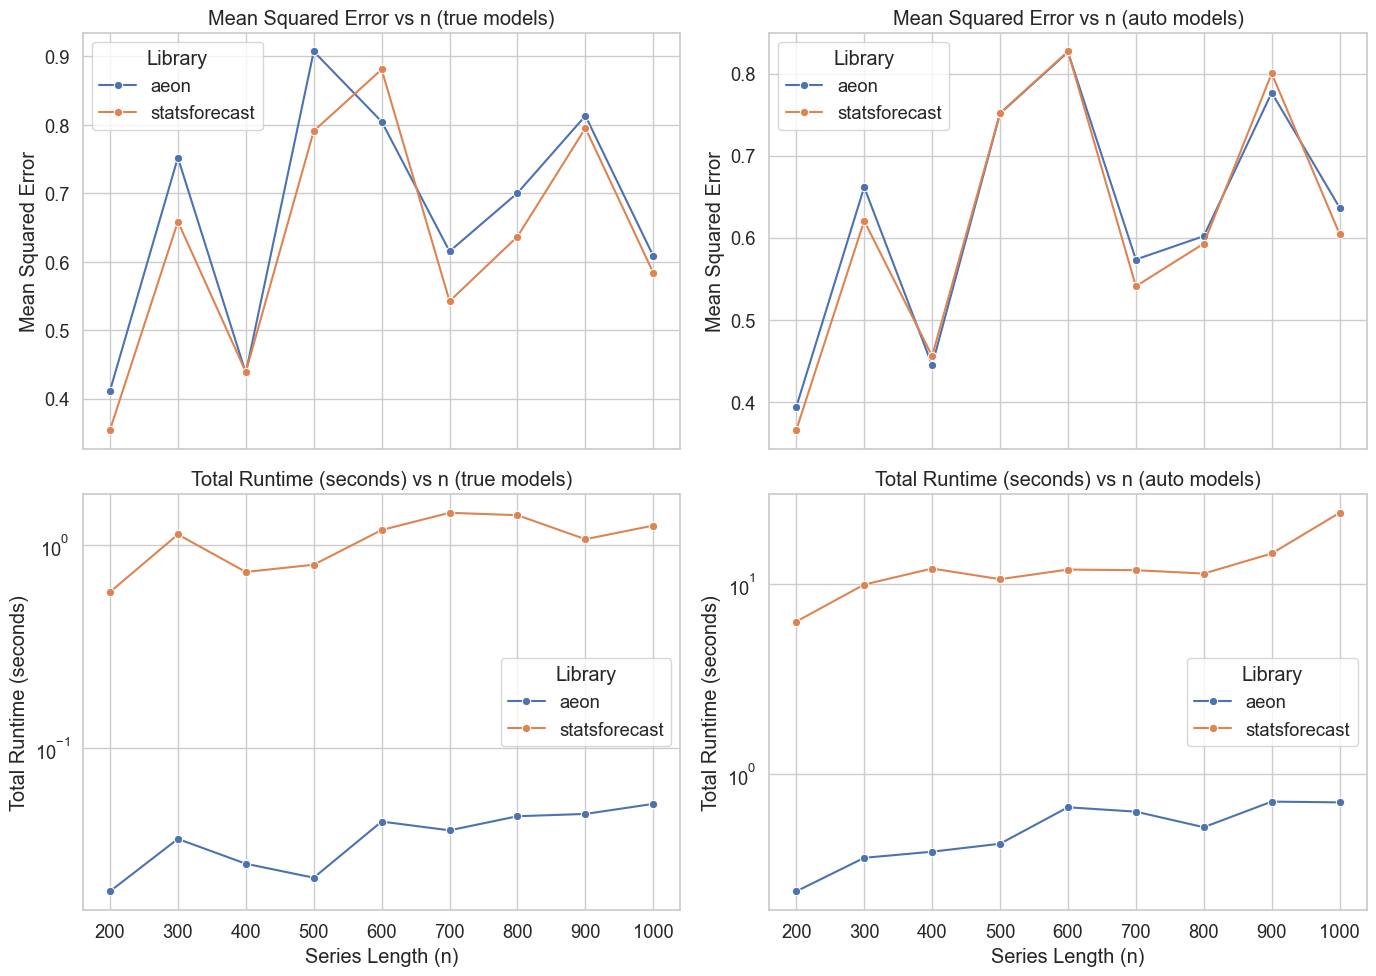

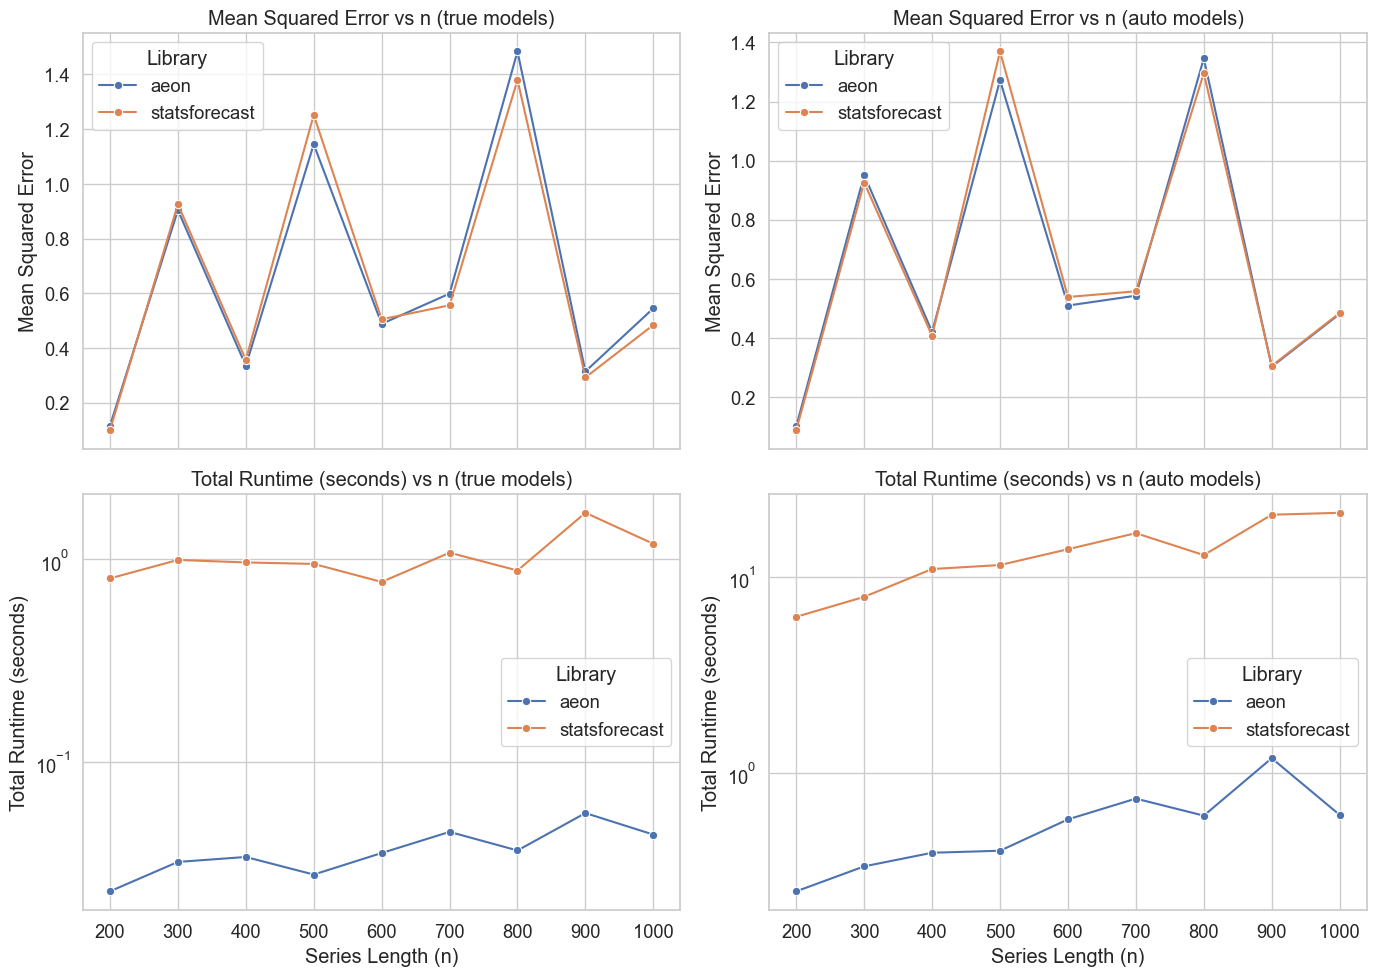

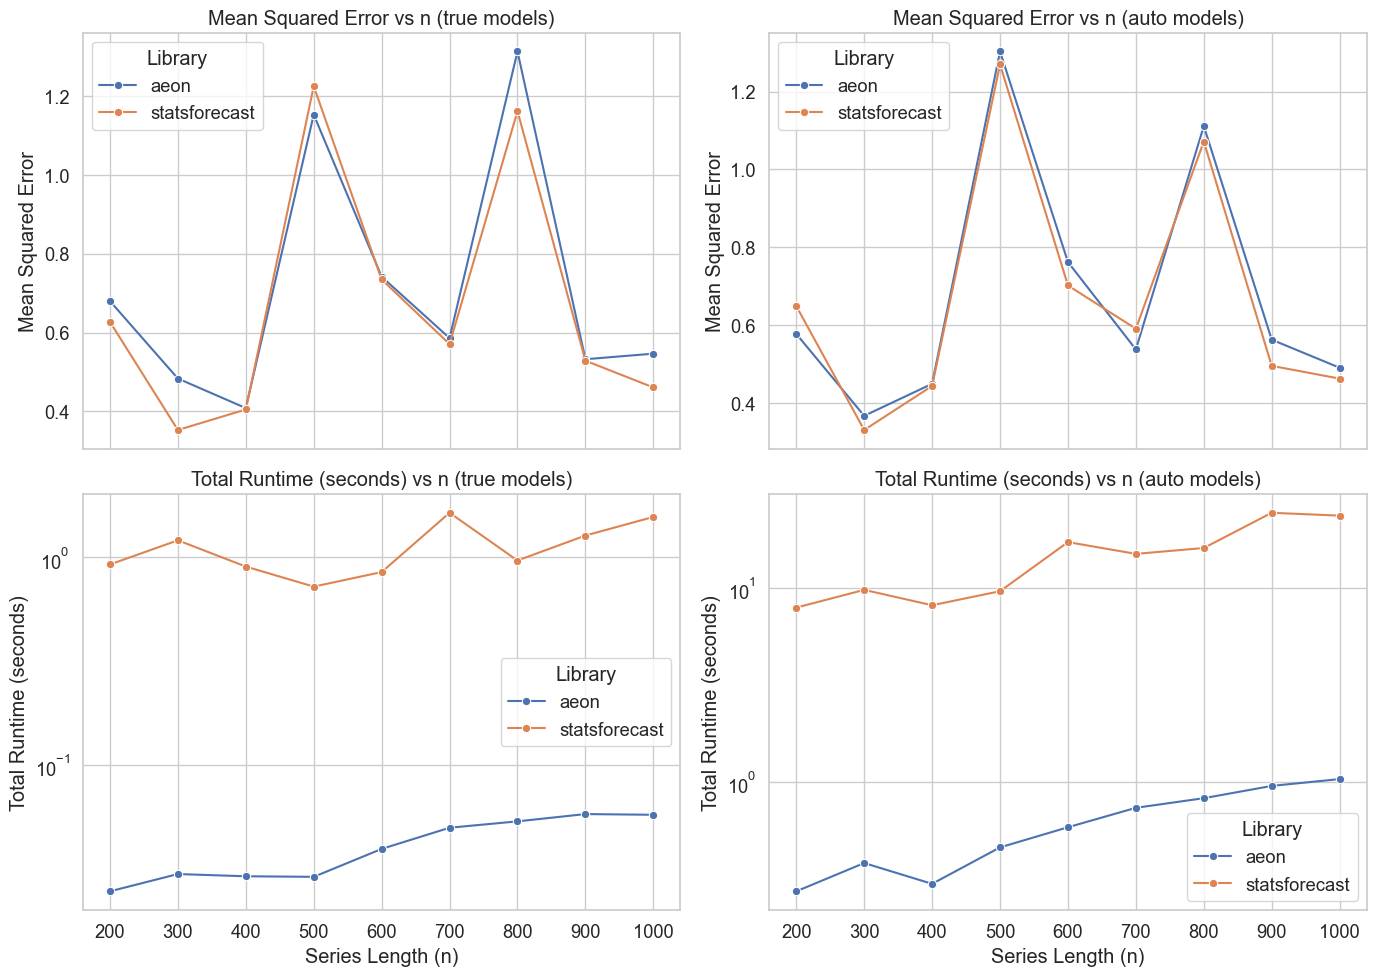

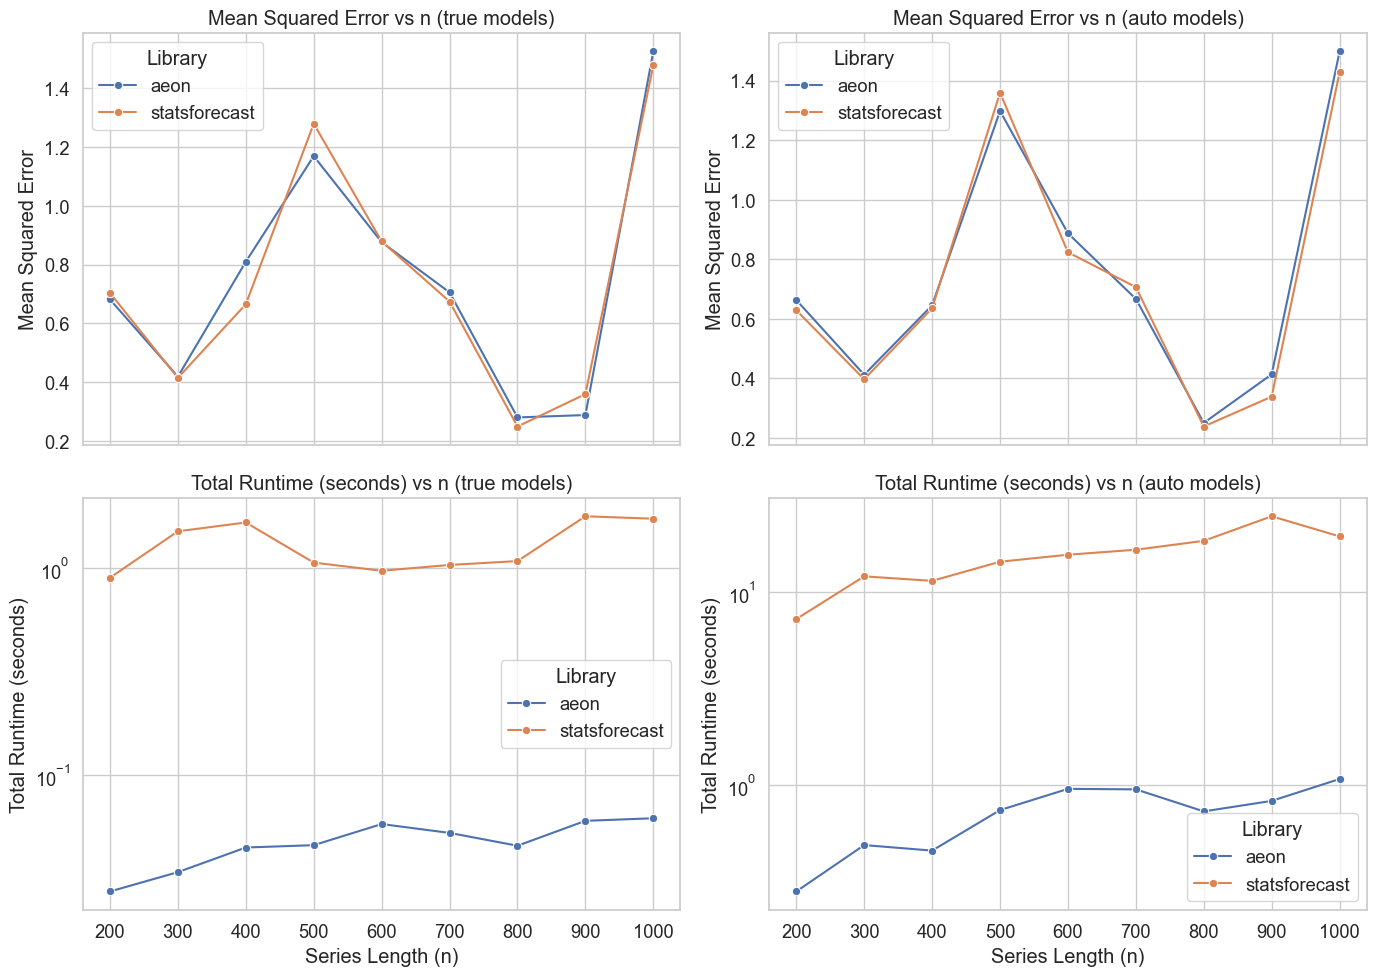

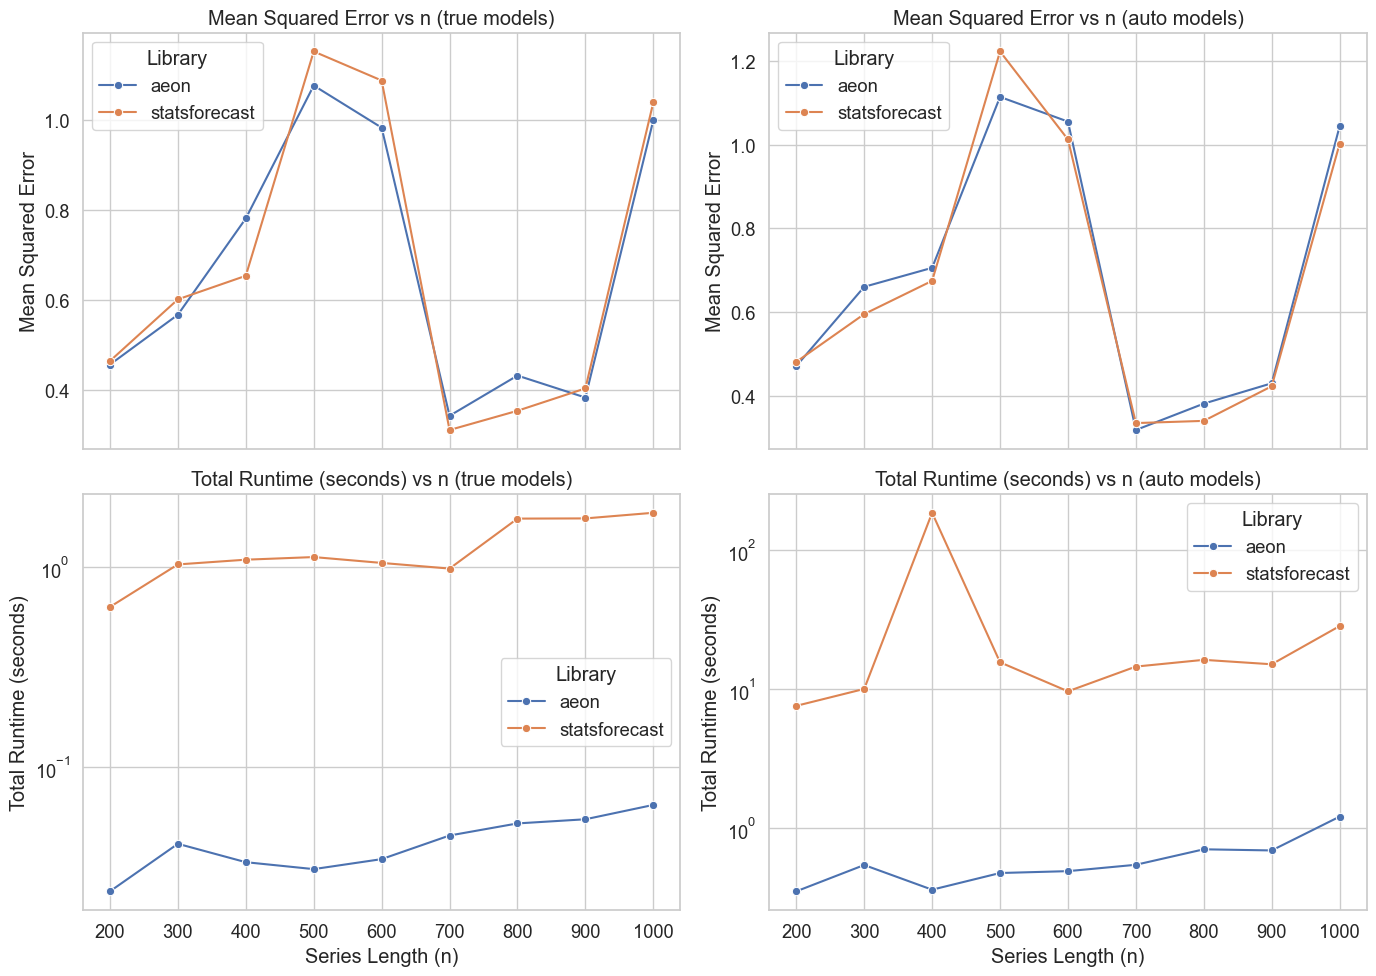

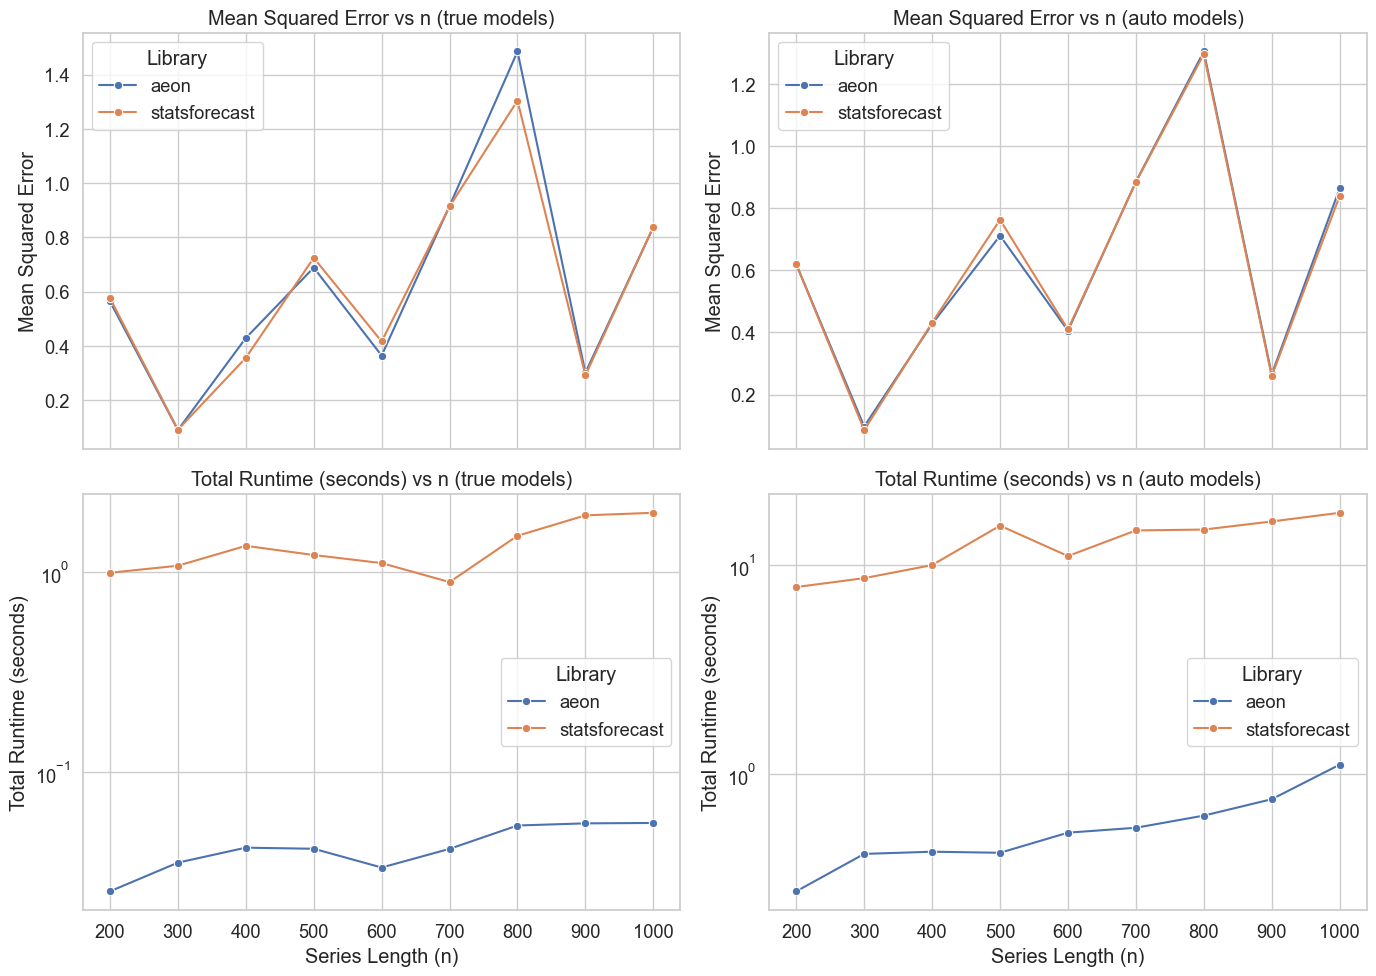

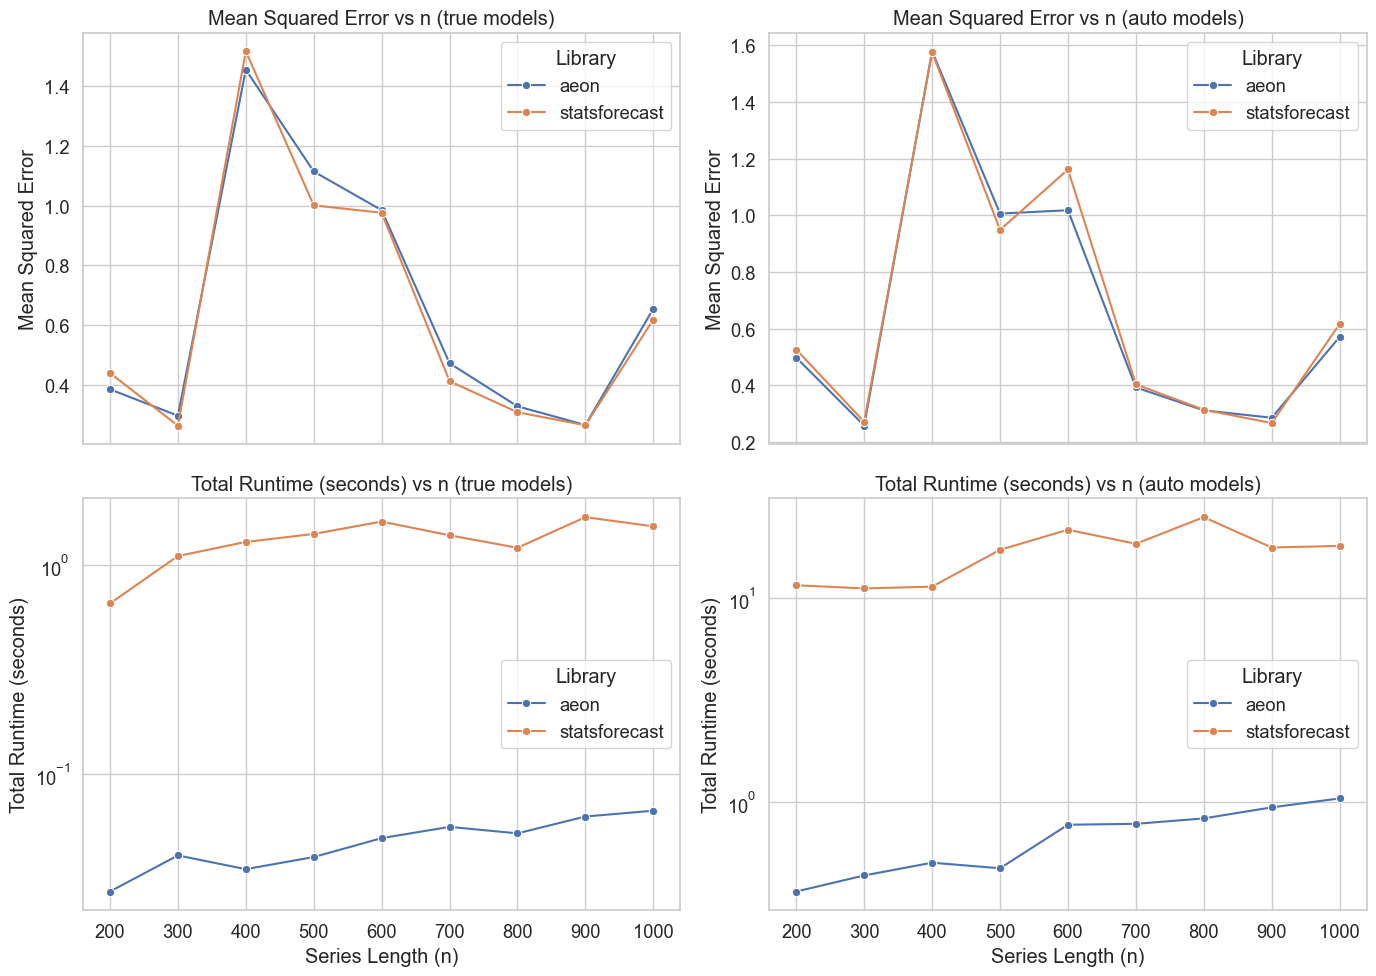

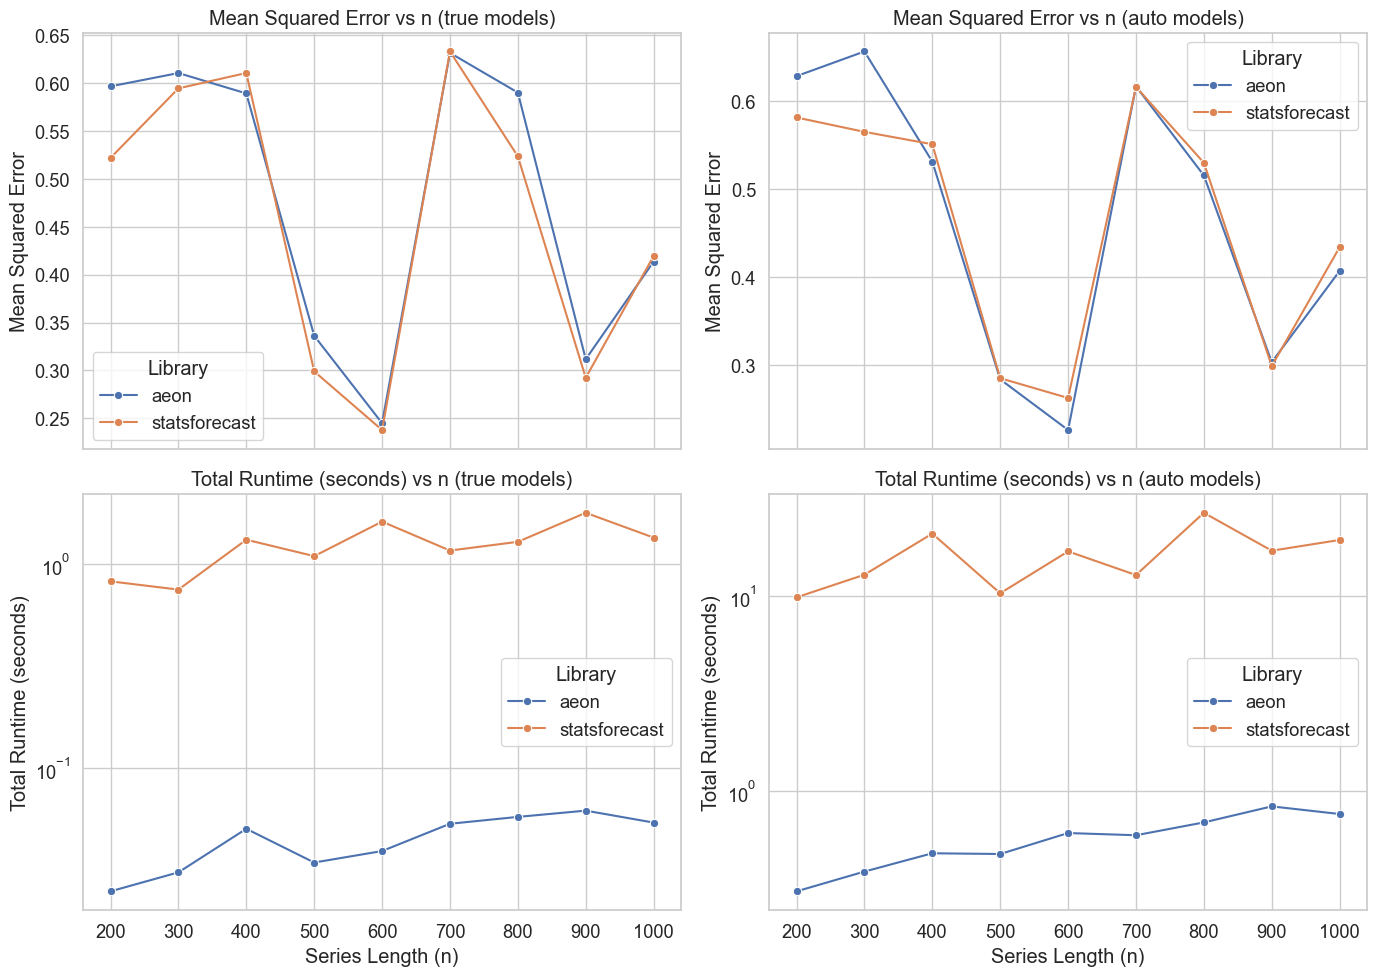

In [8]:
for result in results:
    plot_mse_and_runtime_by_library(result)

In [4]:
from aeon.forecasting.utils._nelder_mead import nelder_mead
from aeon.forecasting.utils._hypo_tests import kpss_test
y = np.array([-0.80390321,  0.27366832, -0.39783559, -0.63576251,  0.33799561, -0.18364153,
 -1.01312568, -0.60825155,  0.11252097,  0.65894515,  0.41467228,  2.13107379,
  2.18714826, -0.25811754,  0.03086796,  0.89568359,  1.13072142, -1.27638275,
 -1.08707844, -0.35680442, -0.41895377, -1.02351458, -1.34147009,  1.59173219,
 -0.24126365,  0.18597677,  0.74434477,  0.53171175,  0.09571292, -0.02886616,
  0.20230787, -0.78384096, -0.2651397 , -0.49613865,  0.19156014, -0.24034904,
  0.39817159,  0.41925381,  0.15148847, -0.0800064 , -2.20080837, -1.12757926,
  1.91081636,  0.5610981 ,  0.31488556,  1.52090749,  0.46879795,  0.68765717,
  0.00596871, -0.00808333,  0.42652293,  0.31541466,  1.10346479, -0.56072961,
 -1.90251721, -0.86281543, -0.83310452, -1.17215361, -0.77926296,  0.85463671,
  0.34065078,  0.84535932, -0.43133694, -0.19213775,  1.32599195,  0.19579684,
 -1.18312175, -1.01954961,  0.96634425,  1.08090926, -0.48697369,  0.21913962,
  1.80731894, -0.58352362, -1.69403086, -0.18433699, -0.13048225, -1.10652588,
  0.02800785,  1.60523622, -0.26448791,  0.38760201,  0.23314536, -3.06049436,
 -0.10506104,  0.43819104, -1.29910526, -0.15325395,  0.87913154,  0.11680615,
 -1.15457783, -2.27833045, -0.55422746, -0.15977338,  0.14409723, -0.81390981,
 -0.70316604,  1.12879211, -1.04031063, -0.47784495,  2.06304988, -0.62203624,
 -2.93479184, -1.17529213,  0.14492865, -0.83747873,  0.61908818, -0.04016299,
  0.12346686, -0.04496771, -0.50056963,  1.33733868, -0.22179811,  0.08393447,
  0.03876012,  0.9018611 ,  1.92721378,  0.36038949, -0.74609684,  0.02026138,
  0.05428255,  0.46135933,  0.07931232, -0.64259447, -1.16693521, -0.10529976,
  1.42011928,  1.16339765, -0.13400937, -0.09513085,  0.77939464, -0.08641263,
  0.51374047, -0.62293619, -1.84733172,  1.16522522,  0.36003356, -1.02049901,
 -0.96703661, -1.81364841, -0.44797937,  0.31535627, -0.22962557, -0.2198765, 
 -0.64691096,  1.82639974,  1.92503334,  0.93928986,  1.86732057,  0.35903303,
  0.73924206, -0.51552376, -1.08956142,  0.23595321, -1.07917496, -0.08102747,
  0.39978097,  0.208734  ,  0.39010671, -0.42434816, -0.77537203,  1.41572437,
  1.5573926 , -0.36641962,  0.44070518, -1.3875688 , -2.54870575, -1.94476624,
  0.59294823,  1.75835771,  0.4459416 ,  1.05700823,  1.8439719 ,  0.67833611,
 -0.77738847,  0.2748169 ,  0.24975983,  1.17667509,  1.35474612, -1.12057291,
 -0.32167651, -0.62348907, -1.54642372, -1.02923071,  0.85202186,  0.97040116,
 -0.88859446, -0.03244556,  0.60336494,  0.90937816,  1.96705821, -0.40721485,
 -0.35540485,  1.85349784,  0.08445902, -0.59008199, -0.49448996, -0.10666504,
 -1.36136331, -1.30346315,  0.95104776,  0.92349881, -0.22668878,  0.11359523,
  0.87348502,  0.77916408, -0.15858923,  1.40332565,  2.07621175, -0.02937111,
  0.110074  ,  1.22963359,  1.85604185,  0.22643774, -0.4211118 ,  0.74794632,
 -0.02243369, -1.64421853, -0.99293662,  1.10152734,  0.02011118, -1.68269652,
 -1.05979884, -1.57162908,  0.13553855,  0.12593751, -0.09615311,  0.13432155,
  0.12522773, -0.45363563, -0.20229284,  0.2582748 ,  0.46723882,  0.73263921,
 -0.27927987,  1.56345165,  1.35855385, -1.36267832,  0.52879904,  0.76398271,
  1.28697383,  0.26074021, -0.87742071,  1.22065701,  0.16302105,  0.99554059,
  1.19919185, -0.49755635,  0.69478891,  0.19535763, -0.14620396, -0.40699855,
  0.27838332,  1.64428986,  2.18047434,  1.23663581, -1.75470918, -1.76593577,
  0.42369273,  0.15537258,  0.04655382,  0.6020607 , -0.97588978, -2.28316365,
  0.07506494,  1.18983265, -1.61905951, -0.73548022, -1.85757681, -2.53693192,
 -0.17665786,  0.90964305,  2.4690597 , -0.06646523, -2.53142298, -1.32985599,
  0.47499373,  0.62224124, -0.54503307,  0.34407417, -0.3429096 , -0.28255591,
 -0.01983329, -0.69020718, -0.62196943, -0.39490209,  1.00171145,  0.56646395,
 -0.45202431, -0.5391932 , -0.29149037, -0.57161956,  0.7143679 , -0.02255762,
 -0.76871156,  0.672844  ,  0.82556439, -0.54167926, -1.47568027, -0.83421643])

y_test = -0.83421643

models = []
models.append([1,2,2])
models.append([1,0,0])
models.append([1,1,0])
models.append([1,0,1])
models = np.array(models)
series = np.array(y.squeeze(), dtype=np.float64)
differenced_series = series.copy()
d_ = 0
while not kpss_test(differenced_series)[1] and d_ <= 3:
    differenced_series = np.diff(differenced_series, n=1)
    d_ += 1
for model in models:
    s = 0.1 / (np.sum(model) + 1)
    points, aic = nelder_mead(
      0,
      np.sum(model[:3]),
      differenced_series,
      model,
      max_iter=200,
      simplex_init=s
    )
    aeon_model = AeonARIMA(p=model[1], d=d_, q=model[2], use_constant=model[0])
    forecast = aeon_model.forecast(y)
    print(f" model ({model[1]}, {d_}, {model[2]}, {model[0]}) forecast = {forecast} mse = {(y_test-forecast)**2} aic = {aeon_model.aic_} nm_aic = {aic} ") #


 model (2, 0, 2, 1) forecast = -0.10449367233885276 mse = 0.5324953030485894 aic = 773.584517475504 nm_aic = 770.4872724946047 
 model (0, 0, 0, 1) forecast = 2.7755575615628914e-17 mse = 0.6959170520819449 aic = 853.3631198904689 nm_aic = 853.363119890469 
 model (1, 0, 0, 1) forecast = -0.2244459151990086 mse = 0.3718200807206661 aic = 831.7705315031346 nm_aic = 830.0096278765128 
 model (0, 0, 1, 1) forecast = -0.10366540327269812 mse = 0.5337048026523149 aic = 799.625089397178 nm_aic = 797.971337244243 


In [5]:
from aeon.forecasting.utils._loss_functions import _arima_fit
model = np.array([1,2,2])
s = 0.1 / (np.sum(model) + 1)
points, aic = nelder_mead(
    0,
    np.sum(model[:3]),
    differenced_series,
    model,
    max_iter=200,
    simplex_init=s
)
aeon_model = AeonARIMA(p=model[1], d=0, q=model[2], use_constant=model[0])
forecast = aeon_model.forecast(y)
print(f"points = {points}")
print(f"phi = {aeon_model.phi_}, theta = {aeon_model.theta_}, c = {aeon_model.c_}")
direct_aic = _arima_fit(points, differenced_series, model)
print(f"nm_aic = {aic}, direct_aic = {direct_aic}")
print(f"residuals = {aeon_model.residuals_}")
print(f"fitted_values = {aeon_model.fitted_values_}")

points = [ 0.00090297  0.41397942  0.2795768   0.10075058 -0.75719269]
phi = [0.41397942 0.2795768 ], theta = [ 0.10075058 -0.75719269], c = 0.0009029739711706522
nm_aic = 770.4872724946047, direct_aic = 770.4872724946047
residuals = [ 0.          0.         -0.28727893 -0.51953753  0.54632904 -0.59515627
 -0.55886187 -0.53274174  0.27717598  0.35020004  0.28411409  2.01082349
  1.2006293  -0.35863694  0.47058503  0.6351966   1.04272102 -1.61988201
  0.07703609 -0.78515652  0.169211   -1.36278796 -0.53610232  1.45444071
 -1.07853558  1.04989554 -0.18853389  0.98463869 -0.57536871  0.58548337
 -0.30805699 -0.38606427 -0.19247154 -0.44106892  0.36887518 -0.55298366
  0.77823542 -0.17641085  0.47275117 -0.44204309 -1.80844318 -0.34753501
  1.65767737 -0.34576145  0.83749644  0.88659206  0.29505739  0.70906486
 -0.25869862  0.35925254  0.19521797  0.39255495  0.9610082  -0.90620932
 -1.16082332 -0.48856988 -0.77466321 -0.87883904 -0.56002753  0.89501213
 -0.31041211  1.17346817 -1.23070871

In [6]:
from aeon.forecasting.utils._loss_functions import _arima_fit
from aeon.forecasting.utils._nelder_mead import nelder_mead
from aeon.forecasting.utils._hypo_tests import kpss_test
import numpy as np
y = np.array([-0.80390321,  0.27366832, -0.39783559, -0.63576251,  0.33799561, -0.18364153,
 -1.01312568, -0.60825155,  0.11252097,  0.65894515,  0.41467228,  2.13107379,
  2.18714826, -0.25811754,  0.03086796,  0.89568359,  1.13072142, -1.27638275,
 -1.08707844, -0.35680442, -0.41895377, -1.02351458, -1.34147009,  1.59173219,
 -0.24126365,  0.18597677,  0.74434477,  0.53171175,  0.09571292, -0.02886616,
  0.20230787, -0.78384096, -0.2651397 , -0.49613865,  0.19156014, -0.24034904,
  0.39817159,  0.41925381,  0.15148847, -0.0800064 , -2.20080837, -1.12757926,
  1.91081636,  0.5610981 ,  0.31488556,  1.52090749,  0.46879795,  0.68765717,
  0.00596871, -0.00808333,  0.42652293,  0.31541466,  1.10346479, -0.56072961,
 -1.90251721, -0.86281543, -0.83310452, -1.17215361, -0.77926296,  0.85463671,
  0.34065078,  0.84535932, -0.43133694, -0.19213775,  1.32599195,  0.19579684,
 -1.18312175, -1.01954961,  0.96634425,  1.08090926, -0.48697369,  0.21913962,
  1.80731894, -0.58352362, -1.69403086, -0.18433699, -0.13048225, -1.10652588,
  0.02800785,  1.60523622, -0.26448791,  0.38760201,  0.23314536, -3.06049436,
 -0.10506104,  0.43819104, -1.29910526, -0.15325395,  0.87913154,  0.11680615,
 -1.15457783, -2.27833045, -0.55422746, -0.15977338,  0.14409723, -0.81390981,
 -0.70316604,  1.12879211, -1.04031063, -0.47784495,  2.06304988, -0.62203624,
 -2.93479184, -1.17529213,  0.14492865, -0.83747873,  0.61908818, -0.04016299,
  0.12346686, -0.04496771, -0.50056963,  1.33733868, -0.22179811,  0.08393447,
  0.03876012,  0.9018611 ,  1.92721378,  0.36038949, -0.74609684,  0.02026138,
  0.05428255,  0.46135933,  0.07931232, -0.64259447, -1.16693521, -0.10529976,
  1.42011928,  1.16339765, -0.13400937, -0.09513085,  0.77939464, -0.08641263,
  0.51374047, -0.62293619, -1.84733172,  1.16522522,  0.36003356, -1.02049901,
 -0.96703661, -1.81364841, -0.44797937,  0.31535627, -0.22962557, -0.2198765, 
 -0.64691096,  1.82639974,  1.92503334,  0.93928986,  1.86732057,  0.35903303,
  0.73924206, -0.51552376, -1.08956142,  0.23595321, -1.07917496, -0.08102747,
  0.39978097,  0.208734  ,  0.39010671, -0.42434816, -0.77537203,  1.41572437,
  1.5573926 , -0.36641962,  0.44070518, -1.3875688 , -2.54870575, -1.94476624,
  0.59294823,  1.75835771,  0.4459416 ,  1.05700823,  1.8439719 ,  0.67833611,
 -0.77738847,  0.2748169 ,  0.24975983,  1.17667509,  1.35474612, -1.12057291,
 -0.32167651, -0.62348907, -1.54642372, -1.02923071,  0.85202186,  0.97040116,
 -0.88859446, -0.03244556,  0.60336494,  0.90937816,  1.96705821, -0.40721485,
 -0.35540485,  1.85349784,  0.08445902, -0.59008199, -0.49448996, -0.10666504,
 -1.36136331, -1.30346315,  0.95104776,  0.92349881, -0.22668878,  0.11359523,
  0.87348502,  0.77916408, -0.15858923,  1.40332565,  2.07621175, -0.02937111,
  0.110074  ,  1.22963359,  1.85604185,  0.22643774, -0.4211118 ,  0.74794632,
 -0.02243369, -1.64421853, -0.99293662,  1.10152734,  0.02011118, -1.68269652,
 -1.05979884, -1.57162908,  0.13553855,  0.12593751, -0.09615311,  0.13432155,
  0.12522773, -0.45363563, -0.20229284,  0.2582748 ,  0.46723882,  0.73263921,
 -0.27927987,  1.56345165,  1.35855385, -1.36267832,  0.52879904,  0.76398271,
  1.28697383,  0.26074021, -0.87742071,  1.22065701,  0.16302105,  0.99554059,
  1.19919185, -0.49755635,  0.69478891,  0.19535763, -0.14620396, -0.40699855,
  0.27838332,  1.64428986,  2.18047434,  1.23663581, -1.75470918, -1.76593577,
  0.42369273,  0.15537258,  0.04655382,  0.6020607 , -0.97588978, -2.28316365,
  0.07506494,  1.18983265, -1.61905951, -0.73548022, -1.85757681, -2.53693192,
 -0.17665786,  0.90964305,  2.4690597 , -0.06646523, -2.53142298, -1.32985599,
  0.47499373,  0.62224124, -0.54503307,  0.34407417, -0.3429096 , -0.28255591,
 -0.01983329, -0.69020718, -0.62196943, -0.39490209,  1.00171145,  0.56646395,
 -0.45202431, -0.5391932 , -0.29149037, -0.57161956,  0.7143679 , -0.02255762,
 -0.76871156,  0.672844  ,  0.82556439, -0.54167926, -1.47568027, -0.83421643])
series = np.array(y.squeeze(), dtype=np.float64)
differenced_series = series.copy()
d_ = 0
while not kpss_test(differenced_series)[1] and d_ <= 3:
    differenced_series = np.diff(differenced_series, n=1)
    d_ += 1
model = np.array([1,2,2])
s = 0.1 / (np.sum(model) + 1)
points, aic = nelder_mead(
    0,
    np.sum(model[:3]),
    differenced_series,
    model,
    max_iter=200,
    simplex_init=s
)
direct_aic = _arima_fit(points, differenced_series, model)
print(points)
print(f"nm_aic = {aic}, direct_aic = {direct_aic}")

[ 0.00090297  0.41397942  0.2795768   0.10075058 -0.75719269]
nm_aic = 770.4872724946047, direct_aic = 770.4872724946047
